## 1. Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from word_segmentation import WordSegmentation
from evaluations import Evaluator

sns.set_theme(style="darkgrid")

## 2. Example prediction

### 2.1. Load parameters
You can load parameters from file or pass the parameters to the `WordSegmentation` constructor.

In [2]:
word_segmentation = WordSegmentation()
word_segmentation.load_params('page_params')
word_segmentation.get_params()

{'kernel_size': 25,
 'sigma': 11,
 'theta': 5,
 'min_word_area': 100,
 'resize_height': 1000}

### 2.2. Predict page

Processing image 1/4: ./data/page/d06-050.png


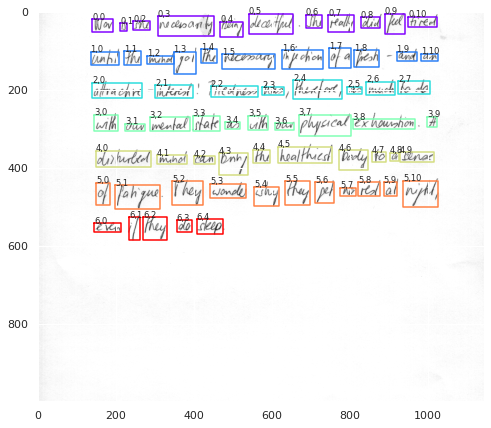

Processing image 2/4: ./data/page/d07-082.png


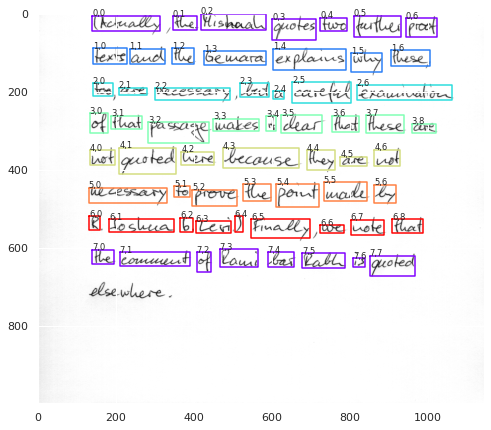

Processing image 3/4: ./data/page/b04-103.png


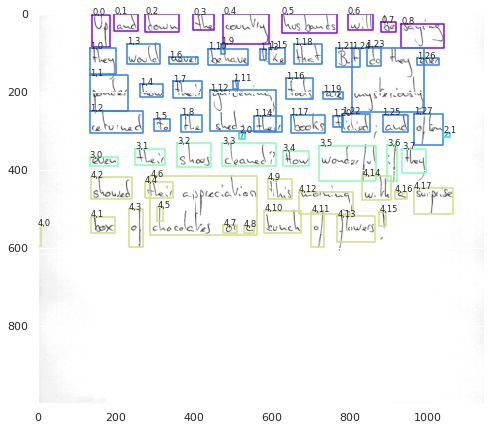

Processing image 4/4: ./data/page/a04-039.png


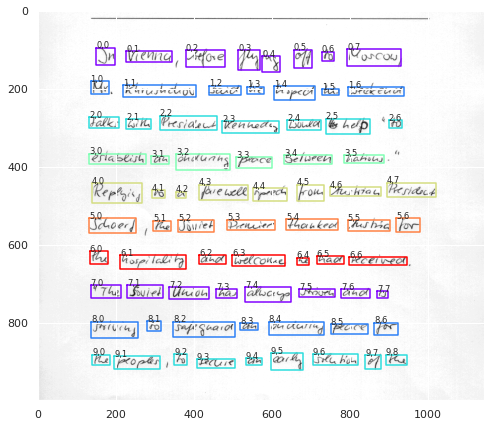

({'d06-050': [[<entities.Word at 0x7f2e70265520>,
  'd07-082': [[<entities.Word at 0x7f2e6f394040>,
  'b04-103': [[<entities.Word at 0x7f2e6e34a520>,
   [<entities.Word at 0x7f2e6f3a6a90>, <entities.Word at 0x7f2e6f3a6eb0>],
  'a04-039': [[<entities.Word at 0x7f2e6e1c5310>,
    <entities.Word at 0x7f2e6e1d7f10>]]},
 {'d06-050': 2.077, 'd07-082': 2.077, 'b04-103': 2.077, 'a04-039': 2.077})

In [3]:
word_segmentation.predict(data='./data/page', is_visualized=True)

### 2.3. Predict line

Processing image 1/6: ./data/line/2.png


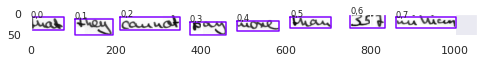

Processing image 2/6: ./data/line/3.png


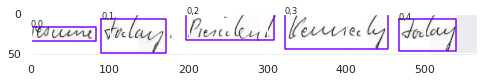

Processing image 3/6: ./data/line/0.png


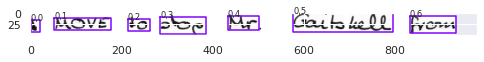

Processing image 4/6: ./data/line/4.png


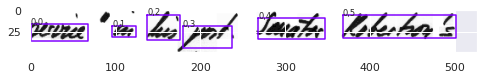

Processing image 5/6: ./data/line/5.png


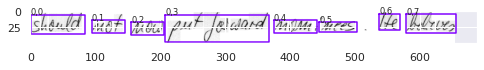

Processing image 6/6: ./data/line/1.png


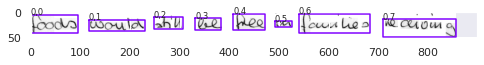

({'2': [[<entities.Word at 0x7f2e6b0276a0>,
  '3': [[<entities.Word at 0x7f2e6af5fdc0>,
  '0': [[<entities.Word at 0x7f2e6af49580>,
  '4': [[<entities.Word at 0x7f2e6ae8f400>,
  '5': [[<entities.Word at 0x7f2e6af63550>,
  '1': [[<entities.Word at 0x7f2e6adb1730>,
    <entities.Word at 0x7f2e6adac910>]]},
 {'2': 1.8199999999999998,
  '3': 3.4,
  '0': 1.7799999999999998,
  '4': 3.6599999999999997,
  '5': 2.88,
  '1': 2.3400000000000003})

In [4]:
word_segmentation_line = WordSegmentation(kernel_size=25,
                                          sigma=11,
                                          theta=7,
                                          min_word_area=100,
                                          resize_height=50)

word_segmentation_line.predict(data='./data/line', is_visualized=True)

## 3. Choose parameters

### 3.1. Sigma and Theta
In order to choose value for `sigma`, we will loop for all sigma values and caculate the maximum area of all words (or we can call extent pixels) detected by the word segmentation.

In [5]:
%%capture capt
def calculate_extent(pages):
    area = 0
    for img_id, lines in pages.items():
        for line in lines:
            for word in line:
                area += word.box.area()
    return area

def calculate_extent_line_of_sigma():
    points = []
    MIN_SIGMA, MAX_SIGMA, STEP = 1, 10, 0.1
    sigma = MIN_SIGMA
    while sigma <= MAX_SIGMA:
        word_segmentation = WordSegmentation(kernel_size=25,
                                             sigma=sigma,
                                             theta=4,
                                             min_word_area=100,
                                             resize_height=1000)
        results, rescale_factor = word_segmentation.predict(data='./data/page')
        points.append((sigma, calculate_extent(results)))
        sigma += STEP
    return points

sigma_points = calculate_extent_line_of_sigma()

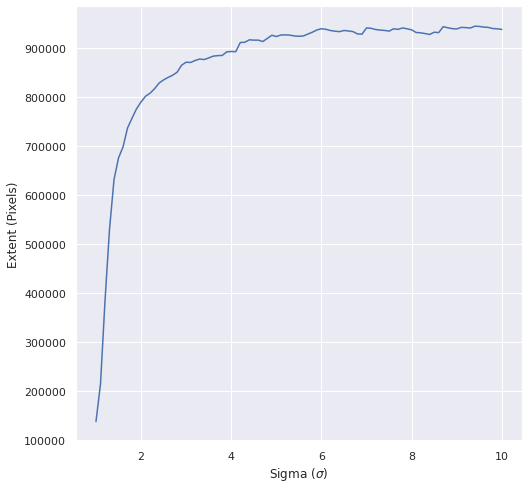

In [6]:
figure, ax = plt.subplots(figsize=(8, 8))
x = [point[0] for point in sigma_points]
y = [point[1] for point in sigma_points]
ax = sns.lineplot(x=x, y=y, ax=ax)
ax.set_xlabel(r"Sigma ($\sigma$)")
ax.set_ylabel("Extent (Pixels)")
plt.show(figure)

In [7]:
figure.savefig('./visualizations/sigma_choice.png', dpi=400)

We can see the the `sigma` value starts to converge from `sigma > 6`. Therefor, we can choose the `sigma` value in the range `[5-7]`.

With `theta` value, we applies the same way to figure out the best parameter.

In [8]:
%%capture capt
def calculate_extent_line_of_theta():
    points = []
    MIN_THETA, MAX_THETA, STEP = 0.3, 10, 0.1
    theta = MIN_THETA
    while theta <= MAX_THETA:
        word_segmentation = WordSegmentation(kernel_size=25,
                                             sigma=5,
                                             theta=theta,
                                             min_word_area=100,
                                             resize_height=1000)
        results, rescale_factor = word_segmentation.predict(data='./data/page')
        points.append((theta, calculate_extent(results)))
        theta += STEP
    return points

theta_points = calculate_extent_line_of_theta()

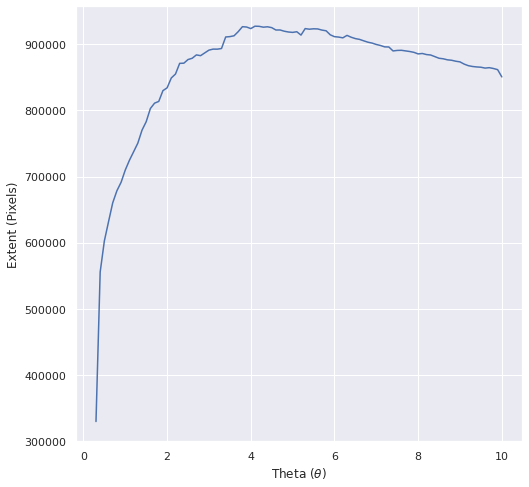

In [9]:
figure, ax = plt.subplots(figsize=(8, 8))
x = [point[0] for point in theta_points]
y = [point[1] for point in theta_points]
ax = sns.lineplot(x=x, y=y, ax=ax)
ax.set_xlabel(r"Theta ($\theta$)")
ax.set_ylabel("Extent (Pixels)")
figure.savefig('./visualizations/theta_choice.png', dpi=400)
plt.show(figure)

As we can see, `theta` value reaches the peak at `theta ~ 4`. There, we can choose `theta` in the range `[3-5]`.

### 3.2. Min word area
To choose the good min word area value, we plots histogram of area of all words.

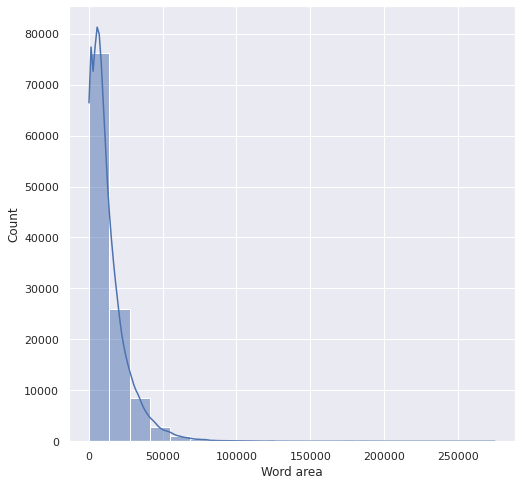

In [19]:
figure, ax = plt.subplots(figsize=(8, 8))
ax = sns.histplot(data=areas, ax=ax, bins=20, kde=True)
ax.set_xlabel(r"Word area")
ax.set_ylabel("Count")
plt.show(figure)

We can choose `min_word_area=100` because only ~3.5% of words in the dataset lower than that threshold.

### 3.3. Kernel size and resize height
`kernel_size = 25` and `resize_height = 1000` are choose from guessing and referencing from the paper and other sources. The `resize_height` correlates with the `kernel_size`: the resized image needs to ensure that the average word height is roughly equal to the kernel size.

## 4. Parameters tuning

In [6]:
sigmas = [5, 6, 7]
thetas = [4, 5, 7]
resize_heights = [800, 1000, 1200]

results = []
for sigma in sigmas:
    for theta in thetas:
        for resize_height in resize_heights:
            evaluator = Evaluator()
            results.append({
                'sigma': sigma,
                'theta': theta,
                'resize_height': resize_height,
                'score': evaluator.evaluate(kernel_size=25,
                                            sigma=sigma,
                                            theta=theta,
                                            min_word_area=100,
                                            resize_height=resize_height)
            })

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 259/529: ./data/preprocessed-forms/d04-066.png
Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preproc

Processing image 387/529: ./data/preprocessed-forms/c03-081d.png
Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/pre

Processing image 516/529: ./data/preprocessed-forms/b06-093.png
Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.5961024787728922
Evaluating on image 2/52

IOU on image a01-117: 0.4702191016096965
Evaluating on image 470/529: d06-113
IOU on image d06-113: 0.37779657011679807
Evaluating on image 471/529: a06-141
IOU on image a06-141: 0.39697593641914736
Evaluating on image 472/529: c04-023
IOU on image c04-023: 0.6173580840499513
Evaluating on image 473/529: a01-122
IOU on image a01-122: 0.2505984077902536
Evaluating on image 474/529: a01-030x
IOU on image a01-030x: 0.5982795609073415
Evaluating on image 475/529: d04-008
IOU on image d04-008: 0.41565058747069195
Evaluating on image 476/529: d01-056
IOU on image d01-056: 0.3452085112984831
Evaluating on image 477/529: c04-089
IOU on image c04-089: 0.32513159904368133
Evaluating on image 478/529: a01-003u
IOU on image a01-003u: 0.4589278974704611
Evaluating on image 479/529: d06-003
IOU on image d06-003: 0.3860019675874856
Evaluating on image 480/529: c03-003f
IOU on image c03-003f: 0.5692902455198
Evaluating on image 481/529: c02-003
IOU on image c02-003: 0.40419292620972397
Evaluating on i

Processing image 55/529: ./data/preprocessed-forms/a04-006.png
Processing image 56/529: ./data/preprocessed-forms/a04-066.png
Processing image 57/529: ./data/preprocessed-forms/a04-031.png
Processing image 58/529: ./data/preprocessed-forms/b01-038.png
Processing image 59/529: ./data/preprocessed-forms/b04-040.png
Processing image 60/529: ./data/preprocessed-forms/a04-019.png
Processing image 61/529: ./data/preprocessed-forms/a03-040.png
Processing image 62/529: ./data/preprocessed-forms/b04-121.png
Processing image 63/529: ./data/preprocessed-forms/b04-181.png
Processing image 64/529: ./data/preprocessed-forms/b05-032.png
Processing image 65/529: ./data/preprocessed-forms/a05-069.png
Processing image 66/529: ./data/preprocessed-forms/d04-005.png
Processing image 67/529: ./data/preprocessed-forms/b01-089.png
Processing image 68/529: ./data/preprocessed-forms/c03-007e.png
Processing image 69/529: ./data/preprocessed-forms/b04-107.png
Processing image 70/529: ./data/preprocessed-forms/b05

Processing image 184/529: ./data/preprocessed-forms/c04-134.png
Processing image 185/529: ./data/preprocessed-forms/d07-085.png
Processing image 186/529: ./data/preprocessed-forms/a06-004.png
Processing image 187/529: ./data/preprocessed-forms/a04-050.png
Processing image 188/529: ./data/preprocessed-forms/c03-007.png
Processing image 189/529: ./data/preprocessed-forms/b06-042.png
Processing image 190/529: ./data/preprocessed-forms/d04-062.png
Processing image 191/529: ./data/preprocessed-forms/c03-007d.png
Processing image 192/529: ./data/preprocessed-forms/d01-019.png
Processing image 193/529: ./data/preprocessed-forms/d05-021.png
Processing image 194/529: ./data/preprocessed-forms/a01-000x.png
Processing image 195/529: ./data/preprocessed-forms/c04-028.png
Processing image 196/529: ./data/preprocessed-forms/a06-134.png
Processing image 197/529: ./data/preprocessed-forms/b04-010.png
Processing image 198/529: ./data/preprocessed-forms/a01-026u.png
Processing image 199/529: ./data/prep

Processing image 312/529: ./data/preprocessed-forms/a02-120.png
Processing image 313/529: ./data/preprocessed-forms/c03-096c.png
Processing image 314/529: ./data/preprocessed-forms/a01-091.png
Processing image 315/529: ./data/preprocessed-forms/c03-081e.png
Processing image 316/529: ./data/preprocessed-forms/c04-122.png
Processing image 317/529: ./data/preprocessed-forms/a01-014u.png
Processing image 318/529: ./data/preprocessed-forms/a01-058u.png
Processing image 319/529: ./data/preprocessed-forms/d04-058.png
Processing image 320/529: ./data/preprocessed-forms/b04-103.png
Processing image 321/529: ./data/preprocessed-forms/c03-096f.png
Processing image 322/529: ./data/preprocessed-forms/c03-087d.png
Processing image 323/529: ./data/preprocessed-forms/d06-000.png
Processing image 324/529: ./data/preprocessed-forms/b04-034.png
Processing image 325/529: ./data/preprocessed-forms/d06-056.png
Processing image 326/529: ./data/preprocessed-forms/a01-068u.png
Processing image 327/529: ./data/

Processing image 441/529: ./data/preprocessed-forms/a01-043u.png
Processing image 442/529: ./data/preprocessed-forms/d06-041.png
Processing image 443/529: ./data/preprocessed-forms/a02-046.png
Processing image 444/529: ./data/preprocessed-forms/d04-089.png
Processing image 445/529: ./data/preprocessed-forms/b01-053.png
Processing image 446/529: ./data/preprocessed-forms/b03-114.png
Processing image 447/529: ./data/preprocessed-forms/b02-045.png
Processing image 448/529: ./data/preprocessed-forms/a01-007u.png
Processing image 449/529: ./data/preprocessed-forms/d06-011.png
Processing image 450/529: ./data/preprocessed-forms/d06-060.png
Processing image 451/529: ./data/preprocessed-forms/c06-111.png
Processing image 452/529: ./data/preprocessed-forms/a06-025.png
Processing image 453/529: ./data/preprocessed-forms/c04-039.png
Processing image 454/529: ./data/preprocessed-forms/a03-047.png
Processing image 455/529: ./data/preprocessed-forms/a03-014.png
Processing image 456/529: ./data/prepr

IOU on image a03-040: 0.6594604591381364
Evaluating on image 62/529: b04-121
IOU on image b04-121: 0.644164408257664
Evaluating on image 63/529: b04-181
IOU on image b04-181: 0.4204753214833445
Evaluating on image 64/529: b05-032
IOU on image b05-032: 0.5502996246195084
Evaluating on image 65/529: a05-069
IOU on image a05-069: 0.33475123120104555
Evaluating on image 66/529: d04-005
IOU on image d04-005: 0.4353716610848733
Evaluating on image 67/529: b01-089
IOU on image b01-089: 0.3861591782403609
Evaluating on image 68/529: c03-007e
IOU on image c03-007e: 0.5022861271381349
Evaluating on image 69/529: b04-107
IOU on image b04-107: 0.318991662650913
Evaluating on image 70/529: b05-045
IOU on image b05-045: 0.4239169454314305
Evaluating on image 71/529: d06-050
IOU on image d06-050: 0.5553702052579566
Evaluating on image 72/529: a01-063x
IOU on image a01-063x: 0.1294752662821204
Evaluating on image 73/529: a05-125
IOU on image a05-125: 0.35105989505067026
Evaluating on image 74/529: a02

IOU on image c04-044: 0.023721407708721852
Evaluating on image 434/529: a05-017
IOU on image a05-017: 0.4476120510515434
Evaluating on image 435/529: d01-016
IOU on image d01-016: 0.7246253846874111
Evaluating on image 436/529: b06-100
IOU on image b06-100: 0.24723519255833995
Evaluating on image 437/529: c03-081b
IOU on image c03-081b: 0.5058475026330775
Evaluating on image 438/529: a03-080
IOU on image a03-080: 0.497981503744074
Evaluating on image 439/529: c06-020
IOU on image c06-020: 0.2814412942507488
Evaluating on image 440/529: d01-104
IOU on image d01-104: 0.6806954793730127
Evaluating on image 441/529: a01-043u
IOU on image a01-043u: 0.490121571125727
Evaluating on image 442/529: d06-041
IOU on image d06-041: 0.5180685366102763
Evaluating on image 443/529: a02-046
IOU on image a02-046: 0.3787332084044644
Evaluating on image 444/529: d04-089
IOU on image d04-089: 0.38491857918592964
Evaluating on image 445/529: b01-053
IOU on image b01-053: 0.6055940383929442
Evaluating on ima

Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
Processing image 17/529: ./data/preprocessed-forms/b04-195.png
Processing image 18/529: ./data/preprocessed-forms/d04-101.png
Processing image 19/529: ./data/preprocessed-forms/d06-067.png
Processing image 20/529: ./data/preprocessed-forms/a04-059.png
Processing image 21/529: ./data/preprocessed-forms/d04-121.png
Processing image 22/529: ./data/preprocessed-forms/a06-044.png
Processing image 23/529: ./data/preprocessed-forms/d04-016.png
Processing image 24/529: ./data/preprocessed-forms/c03-016b.png
Processing image 25/529: ./data/preprocessed-forms/b06-064.png
Processing image 26/529: ./data/preprocessed-forms/b06

Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/preprocessed-forms/a01-132u.png
Processing image 147/529: ./data/preprocessed-forms/b06-004.png
Processing image 148/529: ./data/preprocessed-forms/c02-026.png
Processing image 149/529: ./data/preprocessed-forms/a04-054.png
Processing image 150/529: ./data/preprocessed-forms/d04-071.png
Processing image 151/529: ./data/preprocessed-forms/b02-105.png
Processing image 152/529: ./data/preprocessed-forms/d06-111.png
Processing image 153/529: ./data/preprocessed-forms/a01-063.png
Processing image 154/529: ./data/preprocessed-forms/a02-090.png
Processing image 155/529: ./data/preprocessed-forms/b06-079.png
Processing image 156/529: ./data/prepro

Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preprocessed-forms/a02-037.png
Processing image 275/529: ./data/preprocessed-forms/d01-118.png
Processing image 276/529: ./data/preprocessed-forms/c03-094d.png
Processing image 277/529: ./data/preprocessed-forms/b06-049.png
Processing image 278/529: ./data/preprocessed-forms/c03-007c.png
Processing image 279/529: ./data/preprocessed-forms/c03-000c.png
Processing image 280/529: ./data/preprocessed-forms/a06-051.png
Processing image 281/529: ./data/preprocessed-forms/a05-073.png
Processing image 282/529: ./data/preprocessed-forms/b04-096.png
Processing image 283/529: ./data/preprocessed-forms/c02-030.png
Processing image 284/529: ./data/prep

Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/preprocessed-forms/c04-066.png
Processing image 404/529: ./data/preprocessed-forms/c04-013.png
Processing image 405/529: ./data/preprocessed-forms/c02-012.png
Processing image 406/529: ./data/preprocessed-forms/c06-047.png
Processing image 407/529: ./data/preprocessed-forms/c03-084e.png
Processing image 408/529: ./data/preprocessed-forms/c03-087b.png
Processing image 409/529: ./data/preprocessed-forms/b01-084.png
Processing image 410/529: ./data/preprocessed-forms/c03-087e.png
Processing image 411/529: ./data/preprocessed-forms/c02-007.png
Processing image 412/529: ./data/preprocessed-forms/d04-131.png
Processing image 413/529: ./data/pr

Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.4907254078115472
Evaluating on image 2/529: d01-080
IOU on image d01-080: 0.07950239135428773
Evaluating on image 3/529: a05-039
IOU on image a05-039: 0.17643690492125305
Evaluating on image 4/529: c02-059
IOU on image c02-059: 0.6093252344107524
Evaluating on image 5/529: a01-128
IOU on image a01-128: 0.48821178983701347
Evaluating on image 6/529: c04-080
IOU on image c04-080: 0.12263625031381942
Evaluating on image 7/529: b01-073
IOU on image b01-073: 0.1892139429047332
Evaluating on image 8/529: a02-098
IOU on image a02-098: 0.3021777895080459
Evaluating on image 9/529: a02-106
IOU on image a02-106: 0.2382708714821735
Evaluating on image 10/529: d03-117
IOU on image d03-1

Evaluating on image 345/529: b02-102
IOU on image b02-102: 0.6271947059532049
Evaluating on image 346/529: c06-100
IOU on image c06-100: 0.37014189844820533
Evaluating on image 347/529: b01-122
IOU on image b01-122: 0.5809790744981409
Evaluating on image 348/529: c03-021c
IOU on image c03-021c: 0.30802059542211147
Evaluating on image 349/529: b01-079
IOU on image b01-079: 0.25964746278206574
Evaluating on image 350/529: c03-084a
IOU on image c03-084a: 0.1950251184523033
Evaluating on image 351/529: c03-084f
IOU on image c03-084f: 0.045206540783068475
Evaluating on image 352/529: a01-082u
IOU on image a01-082u: 0.23999293050286216
Evaluating on image 353/529: a05-084
IOU on image a05-084: 0.2767829389445293
Evaluating on image 354/529: c03-094e
IOU on image c03-094e: 0.26027946453626616
Evaluating on image 355/529: a01-077
IOU on image a01-077: 0.1248206299968809
Evaluating on image 356/529: a02-082
IOU on image a02-082: 0.6891297672786608
Evaluating on image 357/529: a03-059
IOU on ima

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 259/529: ./data/preprocessed-forms/d04-066.png
Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preproc

Processing image 387/529: ./data/preprocessed-forms/c03-081d.png
Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/pre

Processing image 516/529: ./data/preprocessed-forms/b06-093.png
Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.5680254001900931
Evaluating on image 2/52

IOU on image a01-107u: 0.34228655670038716
Evaluating on image 421/529: c04-075
IOU on image c04-075: 0.3969165851852544
Evaluating on image 422/529: a03-011
IOU on image a03-011: 0.5427648376305392
Evaluating on image 423/529: c04-150
IOU on image c04-150: 0.2563155690333419
Evaluating on image 424/529: b04-134
IOU on image b04-134: 0.43503790190780267
Evaluating on image 425/529: a01-113u
IOU on image a01-113u: 0.6673058833441247
Evaluating on image 426/529: a02-086
IOU on image a02-086: 0.48603884865700125
Evaluating on image 427/529: b04-047
IOU on image b04-047: 0.3703026405918662
Evaluating on image 428/529: b06-045
IOU on image b06-045: 0.19443966628485249
Evaluating on image 429/529: a05-004
IOU on image a05-004: 0.3312367218388683
Evaluating on image 430/529: b06-019
IOU on image b06-019: 0.38722254713129234
Evaluating on image 431/529: d07-102
IOU on image d07-102: 0.4255385591776686
Evaluating on image 432/529: c03-016c
IOU on image c03-016c: 0.4476464039204394
Evaluating on

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/preprocessed-forms/a01-132u.png
Processing image 147/529: ./data/prep

Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preprocessed-forms/a02-037.png
Processing image 275/529: ./data/preproc

Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/prep

Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.5009555708251497
Evaluating on image 2/529: d01-080
IOU on image d01-080: 0.4127376314988025
Evaluating o

IOU on image c02-017: 0.536027725998868
Evaluating on image 459/529: a03-073
IOU on image a03-073: 0.5505749379229282
Evaluating on image 460/529: a03-071
IOU on image a03-071: 0.3909820057924183
Evaluating on image 461/529: d04-117
IOU on image d04-117: 0.34712540852995905
Evaluating on image 462/529: a06-008
IOU on image a06-008: 0.2972062270830218
Evaluating on image 463/529: b06-097
IOU on image b06-097: 0.49739601690400415
Evaluating on image 464/529: a01-011
IOU on image a01-011: 0.48093036586182186
Evaluating on image 465/529: d06-027
IOU on image d06-027: 0.3803439007774972
Evaluating on image 466/529: b04-169
IOU on image b04-169: 0.5760507357912783
Evaluating on image 467/529: a04-000
IOU on image a04-000: 0.506362131389314
Evaluating on image 468/529: a01-058x
IOU on image a01-058x: 0.3684183269813545
Evaluating on image 469/529: a01-117
IOU on image a01-117: 0.3718117305408466
Evaluating on image 470/529: d06-113
IOU on image d06-113: 0.3671945691468903
Evaluating on image 

Processing image 43/529: ./data/preprocessed-forms/a03-017.png
Processing image 44/529: ./data/preprocessed-forms/d01-085.png
Processing image 45/529: ./data/preprocessed-forms/b05-088.png
Processing image 46/529: ./data/preprocessed-forms/a05-048.png
Processing image 47/529: ./data/preprocessed-forms/a03-020.png
Processing image 48/529: ./data/preprocessed-forms/a05-099.png
Processing image 49/529: ./data/preprocessed-forms/b04-140.png
Processing image 50/529: ./data/preprocessed-forms/c01-014.png
Processing image 51/529: ./data/preprocessed-forms/a06-119.png
Processing image 52/529: ./data/preprocessed-forms/a02-024.png
Processing image 53/529: ./data/preprocessed-forms/c03-021e.png
Processing image 54/529: ./data/preprocessed-forms/c03-003a.png
Processing image 55/529: ./data/preprocessed-forms/a04-006.png
Processing image 56/529: ./data/preprocessed-forms/a04-066.png
Processing image 57/529: ./data/preprocessed-forms/a04-031.png
Processing image 58/529: ./data/preprocessed-forms/b0

Processing image 173/529: ./data/preprocessed-forms/d06-104.png
Processing image 174/529: ./data/preprocessed-forms/a01-003x.png
Processing image 175/529: ./data/preprocessed-forms/d05-013.png
Processing image 176/529: ./data/preprocessed-forms/b01-033.png
Processing image 177/529: ./data/preprocessed-forms/c02-035.png
Processing image 178/529: ./data/preprocessed-forms/c06-080.png
Processing image 179/529: ./data/preprocessed-forms/a05-094.png
Processing image 180/529: ./data/preprocessed-forms/d04-111.png
Processing image 181/529: ./data/preprocessed-forms/c06-138.png
Processing image 182/529: ./data/preprocessed-forms/c04-165.png
Processing image 183/529: ./data/preprocessed-forms/b03-025.png
Processing image 184/529: ./data/preprocessed-forms/c04-134.png
Processing image 185/529: ./data/preprocessed-forms/d07-085.png
Processing image 186/529: ./data/preprocessed-forms/a06-004.png
Processing image 187/529: ./data/preprocessed-forms/a04-050.png
Processing image 188/529: ./data/prepro

Processing image 301/529: ./data/preprocessed-forms/a02-062.png
Processing image 302/529: ./data/preprocessed-forms/d06-076.png
Processing image 303/529: ./data/preprocessed-forms/b04-147.png
Processing image 304/529: ./data/preprocessed-forms/a06-147.png
Processing image 305/529: ./data/preprocessed-forms/a04-081.png
Processing image 306/529: ./data/preprocessed-forms/b04-066.png
Processing image 307/529: ./data/preprocessed-forms/a01-038x.png
Processing image 308/529: ./data/preprocessed-forms/d04-037.png
Processing image 309/529: ./data/preprocessed-forms/b01-044.png
Processing image 310/529: ./data/preprocessed-forms/a05-121.png
Processing image 311/529: ./data/preprocessed-forms/c03-016d.png
Processing image 312/529: ./data/preprocessed-forms/a02-120.png
Processing image 313/529: ./data/preprocessed-forms/c03-096c.png
Processing image 314/529: ./data/preprocessed-forms/a01-091.png
Processing image 315/529: ./data/preprocessed-forms/c03-081e.png
Processing image 316/529: ./data/pre

Processing image 430/529: ./data/preprocessed-forms/b06-019.png
Processing image 431/529: ./data/preprocessed-forms/d07-102.png
Processing image 432/529: ./data/preprocessed-forms/c03-016c.png
Processing image 433/529: ./data/preprocessed-forms/c04-044.png
Processing image 434/529: ./data/preprocessed-forms/a05-017.png
Processing image 435/529: ./data/preprocessed-forms/d01-016.png
Processing image 436/529: ./data/preprocessed-forms/b06-100.png
Processing image 437/529: ./data/preprocessed-forms/c03-081b.png
Processing image 438/529: ./data/preprocessed-forms/a03-080.png
Processing image 439/529: ./data/preprocessed-forms/c06-020.png
Processing image 440/529: ./data/preprocessed-forms/d01-104.png
Processing image 441/529: ./data/preprocessed-forms/a01-043u.png
Processing image 442/529: ./data/preprocessed-forms/d06-041.png
Processing image 443/529: ./data/preprocessed-forms/a02-046.png
Processing image 444/529: ./data/preprocessed-forms/d04-089.png
Processing image 445/529: ./data/prep

IOU on image c06-128: 0.02380177010610564
Evaluating on image 364/529: a01-020x
IOU on image a01-020x: 0.6005649614445249
Evaluating on image 365/529: c02-056
IOU on image c02-056: 0.2395626220107831
Evaluating on image 366/529: a04-015
IOU on image a04-015: 0.327402025603072
Evaluating on image 367/529: b06-036
IOU on image b06-036: 0.43933353281515486
Evaluating on image 368/529: a06-110
IOU on image a06-110: 0.06553018005959199
Evaluating on image 369/529: d01-024
IOU on image d01-024: 0.7325890774491333
Evaluating on image 370/529: b04-187
IOU on image b04-187: 0.35839990060131643
Evaluating on image 371/529: a01-043
IOU on image a01-043: 0.10615116323418057
Evaluating on image 372/529: a01-077u
IOU on image a01-077u: 0.5527691651372286
Evaluating on image 373/529: b06-082
IOU on image b06-082: 0.19037866661987424
Evaluating on image 374/529: a06-128
IOU on image a06-128: 0.06435258269106399
Evaluating on image 375/529: c03-000e
IOU on image c03-000e: 0.4354180030956164
Evaluating 

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 259/529: ./data/preprocessed-forms/d04-066.png
Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preproc

Processing image 387/529: ./data/preprocessed-forms/c03-081d.png
Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/pre

Processing image 515/529: ./data/preprocessed-forms/d06-030.png
Processing image 516/529: ./data/preprocessed-forms/b06-093.png
Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
I

IOU on image b01-062: 0.512568282000942
Evaluating on image 205/529: d04-028
IOU on image d04-028: 0.2425328187968454
Evaluating on image 206/529: d06-037
IOU on image d06-037: 0.26344210696692233
Evaluating on image 207/529: c04-056
IOU on image c04-056: 0.406176552312992
Evaluating on image 208/529: a01-011x
IOU on image a01-011x: 0.2413587280965124
Evaluating on image 209/529: d01-060
IOU on image d01-060: 0.4068305608798207
Evaluating on image 210/529: a05-104
IOU on image a05-104: 0.5309983437187538
Evaluating on image 211/529: b05-098
IOU on image b05-098: 0.44930655584069834
Evaluating on image 212/529: a01-007
IOU on image a01-007: 0.5261001436275838
Evaluating on image 213/529: a04-043
IOU on image a04-043: 0.6245092248305761
Evaluating on image 214/529: a01-128u
IOU on image a01-128u: 0.6001214608835045
Evaluating on image 215/529: b06-012
IOU on image b06-012: 0.4969206662533805
Evaluating on image 216/529: a03-009
IOU on image a03-009: 0.4931099752486028
Evaluating on image

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/preprocessed-forms/a01-132u.png
Processing image 147/529: ./data/prep

Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preprocessed-forms/a02-037.png
Processing image 275/529: ./data/preprocessed-forms/d01-118.png
Processing image 276/529: ./data/preproc

Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/preprocessed-forms/c04-066.png
Processing image 404/529: ./data/prep

Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.44334074493614717
Evaluating on image 2/529: d01-080
IOU on image d01-080: 0.40435506502102064
Evaluating

Evaluating on image 122/529: c03-000a
IOU on image c03-000a: 0.3845252888955918
Evaluating on image 123/529: c06-043
IOU on image c06-043: 0.342302010970268
Evaluating on image 124/529: b05-058
IOU on image b05-058: 0.4974331461432079
Evaluating on image 125/529: c06-095
IOU on image c06-095: 0.28623128998341757
Evaluating on image 126/529: c03-096a
IOU on image c03-096a: 0.38996065470248387
Evaluating on image 127/529: a03-066
IOU on image a03-066: 0.2997012323636696
Evaluating on image 128/529: c06-005
IOU on image c06-005: 0.05233017303620344
Evaluating on image 129/529: c03-084b
IOU on image c03-084b: 0.4283294253495926
Evaluating on image 130/529: b04-026
IOU on image b04-026: 0.3199051654284463
Evaluating on image 131/529: d04-012
IOU on image d04-012: 0.17360858403833415
Evaluating on image 132/529: b05-062
IOU on image b05-062: 0.3904973217172606
Evaluating on image 133/529: c06-031
IOU on image c06-031: 0.5702165460668094
Evaluating on image 134/529: c03-084d
IOU on image c03-

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preprocessed-forms/a02-037.png
Processing image 275/529: ./data/preproc

Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/prep

Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.3117403102424819
Evaluating on image 2/529: d01-080
IOU on image d01-080: 0.26481413295223755
Evaluating 

IOU on image a05-022: 0.555248181141846
Evaluating on image 492/529: a06-020
IOU on image a06-020: 0.41029640271050044
Evaluating on image 493/529: a06-000
IOU on image a06-000: 0.4753895930577099
Evaluating on image 494/529: a01-014x
IOU on image a01-014x: 0.11628060185988408
Evaluating on image 495/529: a06-157
IOU on image a06-157: 0.7393031534077174
Evaluating on image 496/529: a01-007x
IOU on image a01-007x: 0.24875224850587693
Evaluating on image 497/529: a04-047
IOU on image a04-047: 0.617366843923944
Evaluating on image 498/529: a05-108
IOU on image a05-108: 0.471576646425955
Evaluating on image 499/529: d05-025
IOU on image d05-025: 0.5771066006758423
Evaluating on image 500/529: a02-032
IOU on image a02-032: 0.5308724307320659
Evaluating on image 501/529: c03-016a
IOU on image c03-016a: 0.5146597566302502
Evaluating on image 502/529: d04-096
IOU on image d04-096: 0.20830764961194748
Evaluating on image 503/529: d01-052
IOU on image d01-052: 0.4285373960308458
Evaluating on im

Processing image 83/529: ./data/preprocessed-forms/a06-039.png
Processing image 84/529: ./data/preprocessed-forms/d07-096.png
Processing image 85/529: ./data/preprocessed-forms/c03-003b.png
Processing image 86/529: ./data/preprocessed-forms/b05-038.png
Processing image 87/529: ./data/preprocessed-forms/b04-000.png
Processing image 88/529: ./data/preprocessed-forms/a02-057.png
Processing image 89/529: ./data/preprocessed-forms/c06-116.png
Processing image 90/529: ./data/preprocessed-forms/a05-113.png
Processing image 91/529: ./data/preprocessed-forms/c04-170.png
Processing image 92/529: ./data/preprocessed-forms/b03-109.png
Processing image 93/529: ./data/preprocessed-forms/b01-023.png
Processing image 94/529: ./data/preprocessed-forms/b05-055.png
Processing image 95/529: ./data/preprocessed-forms/a01-026.png
Processing image 96/529: ./data/preprocessed-forms/a01-000u.png
Processing image 97/529: ./data/preprocessed-forms/b02-097.png
Processing image 98/529: ./data/preprocessed-forms/a0

Processing image 212/529: ./data/preprocessed-forms/a01-007.png
Processing image 213/529: ./data/preprocessed-forms/a04-043.png
Processing image 214/529: ./data/preprocessed-forms/a01-128u.png
Processing image 215/529: ./data/preprocessed-forms/b06-012.png
Processing image 216/529: ./data/preprocessed-forms/a03-009.png
Processing image 217/529: ./data/preprocessed-forms/b04-175.png
Processing image 218/529: ./data/preprocessed-forms/a02-072.png
Processing image 219/529: ./data/preprocessed-forms/a02-102.png
Processing image 220/529: ./data/preprocessed-forms/c03-096b.png
Processing image 221/529: ./data/preprocessed-forms/c06-106.png
Processing image 222/529: ./data/preprocessed-forms/a06-014.png
Processing image 223/529: ./data/preprocessed-forms/c06-052.png
Processing image 224/529: ./data/preprocessed-forms/a02-020.png
Processing image 225/529: ./data/preprocessed-forms/d04-053.png
Processing image 226/529: ./data/preprocessed-forms/a02-067.png
Processing image 227/529: ./data/prepr

Processing image 341/529: ./data/preprocessed-forms/d06-015.png
Processing image 342/529: ./data/preprocessed-forms/c03-007f.png
Processing image 343/529: ./data/preprocessed-forms/d04-032.png
Processing image 344/529: ./data/preprocessed-forms/a05-025.png
Processing image 345/529: ./data/preprocessed-forms/b02-102.png
Processing image 346/529: ./data/preprocessed-forms/c06-100.png
Processing image 347/529: ./data/preprocessed-forms/b01-122.png
Processing image 348/529: ./data/preprocessed-forms/c03-021c.png
Processing image 349/529: ./data/preprocessed-forms/b01-079.png
Processing image 350/529: ./data/preprocessed-forms/c03-084a.png
Processing image 351/529: ./data/preprocessed-forms/c03-084f.png
Processing image 352/529: ./data/preprocessed-forms/a01-082u.png
Processing image 353/529: ./data/preprocessed-forms/a05-084.png
Processing image 354/529: ./data/preprocessed-forms/c03-094e.png
Processing image 355/529: ./data/preprocessed-forms/a01-077.png
Processing image 356/529: ./data/p

Processing image 469/529: ./data/preprocessed-forms/a01-117.png
Processing image 470/529: ./data/preprocessed-forms/d06-113.png
Processing image 471/529: ./data/preprocessed-forms/a06-141.png
Processing image 472/529: ./data/preprocessed-forms/c04-023.png
Processing image 473/529: ./data/preprocessed-forms/a01-122.png
Processing image 474/529: ./data/preprocessed-forms/a01-030x.png
Processing image 475/529: ./data/preprocessed-forms/d04-008.png
Processing image 476/529: ./data/preprocessed-forms/d01-056.png
Processing image 477/529: ./data/preprocessed-forms/c04-089.png
Processing image 478/529: ./data/preprocessed-forms/a01-003u.png
Processing image 479/529: ./data/preprocessed-forms/d06-003.png
Processing image 480/529: ./data/preprocessed-forms/c03-003f.png
Processing image 481/529: ./data/preprocessed-forms/c02-003.png
Processing image 482/529: ./data/preprocessed-forms/a05-058.png
Processing image 483/529: ./data/preprocessed-forms/c02-049.png
Processing image 484/529: ./data/prep

Evaluating on image 157/529: d06-072
IOU on image d06-072: 0.12762727213471872
Evaluating on image 158/529: b06-059
IOU on image b06-059: 0.4928390877319395
Evaluating on image 159/529: b01-000
IOU on image b01-000: 0.6253853883012644
Evaluating on image 160/529: c02-082
IOU on image c02-082: 0.4153620631479471
Evaluating on image 161/529: b01-027
IOU on image b01-027: 0.6394846040834945
Evaluating on image 162/529: a01-091u
IOU on image a01-091u: 0.6876081197453614
Evaluating on image 163/529: d06-086
IOU on image d06-086: 0.6686225341156007
Evaluating on image 164/529: a03-034
IOU on image a03-034: 0.73611612677621
Evaluating on image 165/529: d07-093
IOU on image d07-093: 0.7366829452267929
Evaluating on image 166/529: b01-018
IOU on image b01-018: 0.5201515902681413
Evaluating on image 167/529: c04-144
IOU on image c04-144: 0.4077514469212005
Evaluating on image 168/529: c06-014
IOU on image c06-014: 0.15699479183347645
Evaluating on image 169/529: c02-000
IOU on image c02-000: 0.6

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/preprocessed-forms/a01-132u.png
Processing image 147/529: ./data/prep

Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preprocessed-forms/a02-037.png
Processing image 275/529: ./data/preprocessed-forms/d01-118.png
Processing image 276/529: ./data/preproc

Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/preprocessed-forms/c04-066.png
Processing image 404/529: ./data/prep

Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.49740895982302585
Evaluating on image 2/529: d01-080
IOU on image d01-080: 0.4134996444505235
Evaluating 

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 259/529: ./data/preprocessed-forms/d04-066.png
Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preproc

Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/prep

Processing image 516/529: ./data/preprocessed-forms/b06-093.png
Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.5560518430040174
Evaluating on image 2/52

IOU on image a03-011: 0.42709437288836716
Evaluating on image 423/529: c04-150
IOU on image c04-150: 0.3879101694649965
Evaluating on image 424/529: b04-134
IOU on image b04-134: 0.2614487113809765
Evaluating on image 425/529: a01-113u
IOU on image a01-113u: 0.4594887221662043
Evaluating on image 426/529: a02-086
IOU on image a02-086: 0.39417456089767455
Evaluating on image 427/529: b04-047
IOU on image b04-047: 0.4184764559492288
Evaluating on image 428/529: b06-045
IOU on image b06-045: 0.09874010236072808
Evaluating on image 429/529: a05-004
IOU on image a05-004: 0.14214305262568952
Evaluating on image 430/529: b06-019
IOU on image b06-019: 0.07628623425884418
Evaluating on image 431/529: d07-102
IOU on image d07-102: 0.34875923923630797
Evaluating on image 432/529: c03-016c
IOU on image c03-016c: 0.4726190556032904
Evaluating on image 433/529: c04-044
IOU on image c04-044: 0.022651285615640022
Evaluating on image 434/529: a05-017
IOU on image a05-017: 0.3299227721424388
Evaluating 

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 259/529: ./data/preprocessed-forms/d04-066.png
Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preproc

Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/prep

Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.566310456664057
Evaluating on image 2/529: d01-080
IOU on image d01-080: 0.3959108362450598
Evaluating on

IOU on image a01-058x: 0.41693329530651557
Evaluating on image 469/529: a01-117
IOU on image a01-117: 0.4128820543622199
Evaluating on image 470/529: d06-113
IOU on image d06-113: 0.3850634720248586
Evaluating on image 471/529: a06-141
IOU on image a06-141: 0.3685729245371919
Evaluating on image 472/529: c04-023
IOU on image c04-023: 0.5889260956262061
Evaluating on image 473/529: a01-122
IOU on image a01-122: 0.30909334396157456
Evaluating on image 474/529: a01-030x
IOU on image a01-030x: 0.5594847169347081
Evaluating on image 475/529: d04-008
IOU on image d04-008: 0.45428235688703716
Evaluating on image 476/529: d01-056
IOU on image d01-056: 0.35135259364186056
Evaluating on image 477/529: c04-089
IOU on image c04-089: 0.3203003964811123
Evaluating on image 478/529: a01-003u
IOU on image a01-003u: 0.43271757643642667
Evaluating on image 479/529: d06-003
IOU on image d06-003: 0.4080150467047394
Evaluating on image 480/529: c03-003f
IOU on image c03-003f: 0.5218996876187005
Evaluating 

Processing image 55/529: ./data/preprocessed-forms/a04-006.png
Processing image 56/529: ./data/preprocessed-forms/a04-066.png
Processing image 57/529: ./data/preprocessed-forms/a04-031.png
Processing image 58/529: ./data/preprocessed-forms/b01-038.png
Processing image 59/529: ./data/preprocessed-forms/b04-040.png
Processing image 60/529: ./data/preprocessed-forms/a04-019.png
Processing image 61/529: ./data/preprocessed-forms/a03-040.png
Processing image 62/529: ./data/preprocessed-forms/b04-121.png
Processing image 63/529: ./data/preprocessed-forms/b04-181.png
Processing image 64/529: ./data/preprocessed-forms/b05-032.png
Processing image 65/529: ./data/preprocessed-forms/a05-069.png
Processing image 66/529: ./data/preprocessed-forms/d04-005.png
Processing image 67/529: ./data/preprocessed-forms/b01-089.png
Processing image 68/529: ./data/preprocessed-forms/c03-007e.png
Processing image 69/529: ./data/preprocessed-forms/b04-107.png
Processing image 70/529: ./data/preprocessed-forms/b05

Processing image 184/529: ./data/preprocessed-forms/c04-134.png
Processing image 185/529: ./data/preprocessed-forms/d07-085.png
Processing image 186/529: ./data/preprocessed-forms/a06-004.png
Processing image 187/529: ./data/preprocessed-forms/a04-050.png
Processing image 188/529: ./data/preprocessed-forms/c03-007.png
Processing image 189/529: ./data/preprocessed-forms/b06-042.png
Processing image 190/529: ./data/preprocessed-forms/d04-062.png
Processing image 191/529: ./data/preprocessed-forms/c03-007d.png
Processing image 192/529: ./data/preprocessed-forms/d01-019.png
Processing image 193/529: ./data/preprocessed-forms/d05-021.png
Processing image 194/529: ./data/preprocessed-forms/a01-000x.png
Processing image 195/529: ./data/preprocessed-forms/c04-028.png
Processing image 196/529: ./data/preprocessed-forms/a06-134.png
Processing image 197/529: ./data/preprocessed-forms/b04-010.png
Processing image 198/529: ./data/preprocessed-forms/a01-026u.png
Processing image 199/529: ./data/prep

Processing image 312/529: ./data/preprocessed-forms/a02-120.png
Processing image 313/529: ./data/preprocessed-forms/c03-096c.png
Processing image 314/529: ./data/preprocessed-forms/a01-091.png
Processing image 315/529: ./data/preprocessed-forms/c03-081e.png
Processing image 316/529: ./data/preprocessed-forms/c04-122.png
Processing image 317/529: ./data/preprocessed-forms/a01-014u.png
Processing image 318/529: ./data/preprocessed-forms/a01-058u.png
Processing image 319/529: ./data/preprocessed-forms/d04-058.png
Processing image 320/529: ./data/preprocessed-forms/b04-103.png
Processing image 321/529: ./data/preprocessed-forms/c03-096f.png
Processing image 322/529: ./data/preprocessed-forms/c03-087d.png
Processing image 323/529: ./data/preprocessed-forms/d06-000.png
Processing image 324/529: ./data/preprocessed-forms/b04-034.png
Processing image 325/529: ./data/preprocessed-forms/d06-056.png
Processing image 326/529: ./data/preprocessed-forms/a01-068u.png
Processing image 327/529: ./data/

Processing image 440/529: ./data/preprocessed-forms/d01-104.png
Processing image 441/529: ./data/preprocessed-forms/a01-043u.png
Processing image 442/529: ./data/preprocessed-forms/d06-041.png
Processing image 443/529: ./data/preprocessed-forms/a02-046.png
Processing image 444/529: ./data/preprocessed-forms/d04-089.png
Processing image 445/529: ./data/preprocessed-forms/b01-053.png
Processing image 446/529: ./data/preprocessed-forms/b03-114.png
Processing image 447/529: ./data/preprocessed-forms/b02-045.png
Processing image 448/529: ./data/preprocessed-forms/a01-007u.png
Processing image 449/529: ./data/preprocessed-forms/d06-011.png
Processing image 450/529: ./data/preprocessed-forms/d06-060.png
Processing image 451/529: ./data/preprocessed-forms/c06-111.png
Processing image 452/529: ./data/preprocessed-forms/a06-025.png
Processing image 453/529: ./data/preprocessed-forms/c04-039.png
Processing image 454/529: ./data/preprocessed-forms/a03-047.png
Processing image 455/529: ./data/prepr

IOU on image c03-016c: 0.6822609678838829
Evaluating on image 433/529: c04-044
IOU on image c04-044: 0.032685658845174284
Evaluating on image 434/529: a05-017
IOU on image a05-017: 0.561631604713154
Evaluating on image 435/529: d01-016
IOU on image d01-016: 0.6870596399460529
Evaluating on image 436/529: b06-100
IOU on image b06-100: 0.30134562895012085
Evaluating on image 437/529: c03-081b
IOU on image c03-081b: 0.4560380658608299
Evaluating on image 438/529: a03-080
IOU on image a03-080: 0.5244565354473171
Evaluating on image 439/529: c06-020
IOU on image c06-020: 0.27780100682668263
Evaluating on image 440/529: d01-104
IOU on image d01-104: 0.6753327090649106
Evaluating on image 441/529: a01-043u
IOU on image a01-043u: 0.5224443916836612
Evaluating on image 442/529: d06-041
IOU on image d06-041: 0.5717950635920653
Evaluating on image 443/529: a02-046
IOU on image a02-046: 0.35670255263656364
Evaluating on image 444/529: d04-089
IOU on image d04-089: 0.3889893409199531
Evaluating on 

Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
Processing image 17/529: ./data/preprocessed-forms/b04-195.png
Processing image 18/529: ./data/preprocessed-forms/d04-101.png
Processing image 19/529: ./data/preprocessed-forms/d06-067.png
Processing image 20/529: ./data/preprocessed-forms/a04-059.png
Processing image 21/529: ./data/preprocessed-forms/d04-121.png
Processing image 22/529: ./data/preprocessed-forms/a06-044.png
Processing image 23/529: ./data/preprocessed-forms/d04-016.png
Processing image 24/529: ./data/preprocessed-forms/c03-016b.png
Processing image 25/529: ./data/preprocessed-forms/b06-064.png
Processing image 26/529: ./data/preprocessed-forms/b06

Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/preprocessed-forms/a01-132u.png
Processing image 147/529: ./data/preprocessed-forms/b06-004.png
Processing image 148/529: ./data/preprocessed-forms/c02-026.png
Processing image 149/529: ./data/preprocessed-forms/a04-054.png
Processing image 150/529: ./data/preprocessed-forms/d04-071.png
Processing image 151/529: ./data/preprocessed-forms/b02-105.png
Processing image 152/529: ./data/preprocessed-forms/d06-111.png
Processing image 153/529: ./data/preprocessed-forms/a01-063.png
Processing image 154/529: ./data/preprocessed-forms/a02-090.png
Processing image 155/529: ./data/preprocessed-forms/b06-079.png
Processing image 156/529: ./data/preprocessed-forms/c04-098.png
Processing image 157/529: ./data/prepro

Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preprocessed-forms/a02-037.png
Processing image 275/529: ./data/preprocessed-forms/d01-118.png
Processing image 276/529: ./data/preprocessed-forms/c03-094d.png
Processing image 277/529: ./data/preprocessed-forms/b06-049.png
Processing image 278/529: ./data/preprocessed-forms/c03-007c.png
Processing image 279/529: ./data/preprocessed-forms/c03-000c.png
Processing image 280/529: ./data/preprocessed-forms/a06-051.png
Processing image 281/529: ./data/preprocessed-forms/a05-073.png
Processing image 282/529: ./data/preprocessed-forms/b04-096.png
Processing image 283/529: ./data/preprocessed-forms/c02-030.png
Processing image 284/529: ./data/preprocessed-forms/c04-050.png
Processing image 285/529: ./data/prep

Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/preprocessed-forms/c04-066.png
Processing image 404/529: ./data/preprocessed-forms/c04-013.png
Processing image 405/529: ./data/preprocessed-forms/c02-012.png
Processing image 406/529: ./data/preprocessed-forms/c06-047.png
Processing image 407/529: ./data/preprocessed-forms/c03-084e.png
Processing image 408/529: ./data/preprocessed-forms/c03-087b.png
Processing image 409/529: ./data/preprocessed-forms/b01-084.png
Processing image 410/529: ./data/preprocessed-forms/c03-087e.png
Processing image 411/529: ./data/preprocessed-forms/c02-007.png
Processing image 412/529: ./data/preprocessed-forms/d04-131.png
Processing image 413/529: ./data/pr

Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.534527938221833
Evaluating on image 2/529: d01-080
IOU on image d01-080: 0.2569389302626805
Evaluating on image 3/529: a05-039
IOU on image a05-039: 0.3512377226587526
Evaluating on image 4/529: c02-059
IOU on image c02-059: 0.6501166134986021
Evaluating on image 5/529: a01-128
IOU on image a01-128: 0.30890584368200485
Evaluating on image 6/529: c04-080
IOU on image c04-080: 0.22893042066377062
Evaluating on image 7/529: b01-073
IOU on image b01-073: 0.4453722021208137
Evaluating on image 8/529: a02-098
IOU on image a02-098: 0.4469481566607313
Evaluating on image 9/529: a02-106
IOU on image a02-106: 0.38683706327687284
Evaluating on image 10/529: d03-117
IOU on image d03-117

IOU on image c03-087e: 0.21821692296918943
Evaluating on image 411/529: c02-007
IOU on image c02-007: 0.39680766500710485
Evaluating on image 412/529: d04-131
IOU on image d04-131: 0.32789326103931754
Evaluating on image 413/529: b01-057
IOU on image b01-057: 0.6539560729432623
Evaluating on image 414/529: d05-008
IOU on image d05-008: 0.46660769979313216
Evaluating on image 415/529: b04-081
IOU on image b04-081: 0.045919856678088046
Evaluating on image 416/529: b06-015
IOU on image b06-015: 0.1538163896162677
Evaluating on image 417/529: c03-084c
IOU on image c03-084c: 0.5767457611224985
Evaluating on image 418/529: a01-053x
IOU on image a01-053x: 0.5168162122367752
Evaluating on image 419/529: a01-058
IOU on image a01-058: 0.0003638076067184369
Evaluating on image 420/529: a01-107u
IOU on image a01-107u: 0.3185990220661117
Evaluating on image 421/529: c04-075
IOU on image c04-075: 0.4848889595675483
Evaluating on image 422/529: a03-011
IOU on image a03-011: 0.4895972507883407
Evaluat

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 259/529: ./data/preprocessed-forms/d04-066.png
Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preproc

Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/prep

Processing image 516/529: ./data/preprocessed-forms/b06-093.png
Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.515038057409281
Evaluating on image 2/529

IOU on image a04-099: 0.47917426239850297
Evaluating on image 519/529: a02-053
IOU on image a02-053: 0.37355999118701644
Evaluating on image 520/529: b04-154
IOU on image b04-154: 0.408312420093577
Evaluating on image 521/529: a06-075
IOU on image a06-075: 0.013937557365901193
Evaluating on image 522/529: a06-070
IOU on image a06-070: 0.3847581985759823
Evaluating on image 523/529: b02-013
IOU on image b02-013: 0.5293399512727146
Evaluating on image 524/529: c03-021d
IOU on image c03-021d: 0.560611108218294
Evaluating on image 525/529: c06-076
IOU on image c06-076: 0.31225537581546553
Evaluating on image 526/529: a03-030
IOU on image a03-030: 0.5934353986928266
Evaluating on image 527/529: a04-039
IOU on image a04-039: 0.4642764280584377
Evaluating on image 528/529: a01-011u
IOU on image a01-011u: 0.61195889519007
Evaluating on image 529/529: c03-000f
IOU on image c03-000f: 0.5892036359297222
Mean of IOU: 0.4224113017938638
Processing image 1/529: ./data/preprocessed-forms/c04-160.png


Processing image 116/529: ./data/preprocessed-forms/d06-063.png
Processing image 117/529: ./data/preprocessed-forms/a03-037.png
Processing image 118/529: ./data/preprocessed-forms/b05-071.png
Processing image 119/529: ./data/preprocessed-forms/a02-078.png
Processing image 120/529: ./data/preprocessed-forms/a01-122u.png
Processing image 121/529: ./data/preprocessed-forms/c04-035.png
Processing image 122/529: ./data/preprocessed-forms/c03-000a.png
Processing image 123/529: ./data/preprocessed-forms/c06-043.png
Processing image 124/529: ./data/preprocessed-forms/b05-058.png
Processing image 125/529: ./data/preprocessed-forms/c06-095.png
Processing image 126/529: ./data/preprocessed-forms/c03-096a.png
Processing image 127/529: ./data/preprocessed-forms/a03-066.png
Processing image 128/529: ./data/preprocessed-forms/c06-005.png
Processing image 129/529: ./data/preprocessed-forms/c03-084b.png
Processing image 130/529: ./data/preprocessed-forms/b04-026.png
Processing image 131/529: ./data/pre

Processing image 244/529: ./data/preprocessed-forms/a01-072u.png
Processing image 245/529: ./data/preprocessed-forms/b01-094.png
Processing image 246/529: ./data/preprocessed-forms/b01-009.png
Processing image 247/529: ./data/preprocessed-forms/d04-075.png
Processing image 248/529: ./data/preprocessed-forms/a03-027.png
Processing image 249/529: ./data/preprocessed-forms/c04-116.png
Processing image 250/529: ./data/preprocessed-forms/a01-003.png
Processing image 251/529: ./data/preprocessed-forms/b06-008.png
Processing image 252/529: ./data/preprocessed-forms/b03-098.png
Processing image 253/529: ./data/preprocessed-forms/b05-050.png
Processing image 254/529: ./data/preprocessed-forms/a03-043.png
Processing image 255/529: ./data/preprocessed-forms/a06-090.png
Processing image 256/529: ./data/preprocessed-forms/a05-009.png
Processing image 257/529: ./data/preprocessed-forms/a01-026x.png
Processing image 258/529: ./data/preprocessed-forms/c03-007a.png
Processing image 259/529: ./data/prep

Processing image 372/529: ./data/preprocessed-forms/a01-077u.png
Processing image 373/529: ./data/preprocessed-forms/b06-082.png
Processing image 374/529: ./data/preprocessed-forms/a06-128.png
Processing image 375/529: ./data/preprocessed-forms/c03-000e.png
Processing image 376/529: ./data/preprocessed-forms/a01-049u.png
Processing image 377/529: ./data/preprocessed-forms/c04-004.png
Processing image 378/529: ./data/preprocessed-forms/a01-102u.png
Processing image 379/529: ./data/preprocessed-forms/c03-000d.png
Processing image 380/529: ./data/preprocessed-forms/a01-132x.png
Processing image 381/529: ./data/preprocessed-forms/d07-100.png
Processing image 382/529: ./data/preprocessed-forms/c04-128.png
Processing image 383/529: ./data/preprocessed-forms/c04-008.png
Processing image 384/529: ./data/preprocessed-forms/c02-089.png
Processing image 385/529: ./data/preprocessed-forms/a01-072x.png
Processing image 386/529: ./data/preprocessed-forms/c03-087a.png
Processing image 387/529: ./data

Processing image 501/529: ./data/preprocessed-forms/c03-016a.png
Processing image 502/529: ./data/preprocessed-forms/d04-096.png
Processing image 503/529: ./data/preprocessed-forms/d01-052.png
Processing image 504/529: ./data/preprocessed-forms/c03-094f.png
Processing image 505/529: ./data/preprocessed-forms/c04-017.png
Processing image 506/529: ./data/preprocessed-forms/c06-083.png
Processing image 507/529: ./data/preprocessed-forms/a01-030u.png
Processing image 508/529: ./data/preprocessed-forms/c04-000.png
Processing image 509/529: ./data/preprocessed-forms/a06-100.png
Processing image 510/529: ./data/preprocessed-forms/a04-092.png
Processing image 511/529: ./data/preprocessed-forms/b04-202.png
Processing image 512/529: ./data/preprocessed-forms/a04-003.png
Processing image 513/529: ./data/preprocessed-forms/b05-067.png
Processing image 514/529: ./data/preprocessed-forms/d06-096.png
Processing image 515/529: ./data/preprocessed-forms/d06-030.png
Processing image 516/529: ./data/prep

IOU on image c03-084f: 0.4068282551014303
Evaluating on image 352/529: a01-082u
IOU on image a01-082u: 0.5186078463836403
Evaluating on image 353/529: a05-084
IOU on image a05-084: 0.4928364301769925
Evaluating on image 354/529: c03-094e
IOU on image c03-094e: 0.42485240990832174
Evaluating on image 355/529: a01-077
IOU on image a01-077: 0.43695712132901193
Evaluating on image 356/529: a02-082
IOU on image a02-082: 0.6413217048991221
Evaluating on image 357/529: a03-059
IOU on image a03-059: 0.19162760436585802
Evaluating on image 358/529: c03-000b
IOU on image c03-000b: 0.42117975697583315
Evaluating on image 359/529: a05-029
IOU on image a05-029: 0.5862676524941701
Evaluating on image 360/529: d04-021
IOU on image d04-021: 0.3079405351871334
Evaluating on image 361/529: c02-022
IOU on image c02-022: 0.4921410574112474
Evaluating on image 362/529: a04-010
IOU on image a04-010: 0.5257684373497992
Evaluating on image 363/529: c06-128
IOU on image c06-128: 0.2034059996921295
Evaluating o

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preprocessed-forms/a02-037.png
Processing image 275/529: ./data/preproc

Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/prep

Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.31298231056405335
Evaluating on image 2/529: d01-080
IOU on image d01-080: 0.3743168202358431
Evaluating 

IOU on image c03-003f: 0.056834285169835116
Evaluating on image 481/529: c02-003
IOU on image c02-003: 0.31241801582318807
Evaluating on image 482/529: a05-058
IOU on image a05-058: 0.2918756210194126
Evaluating on image 483/529: c02-049
IOU on image c02-049: 0.30767741538613125
Evaluating on image 484/529: d04-125
IOU on image d04-125: 0.3836658389189507
Evaluating on image 485/529: b01-014
IOU on image b01-014: 0.4137871966166248
Evaluating on image 486/529: c03-021a
IOU on image c03-021a: 0.4673078172725505
Evaluating on image 487/529: a05-053
IOU on image a05-053: 0.5396851284737856
Evaluating on image 488/529: b03-092
IOU on image b03-092: 0.477559188224437
Evaluating on image 489/529: a03-023
IOU on image a03-023: 0.30913057529641386
Evaluating on image 490/529: d04-086
IOU on image d04-086: 0.46014047651504225
Evaluating on image 491/529: a05-022
IOU on image a05-022: 0.6864884515436009
Evaluating on image 492/529: a06-020
IOU on image a06-020: 0.3586680162619723
Evaluating on i

Processing image 69/529: ./data/preprocessed-forms/b04-107.png
Processing image 70/529: ./data/preprocessed-forms/b05-045.png
Processing image 71/529: ./data/preprocessed-forms/d06-050.png
Processing image 72/529: ./data/preprocessed-forms/a01-063x.png
Processing image 73/529: ./data/preprocessed-forms/a05-125.png
Processing image 74/529: ./data/preprocessed-forms/a02-042.png
Processing image 75/529: ./data/preprocessed-forms/d05-040.png
Processing image 76/529: ./data/preprocessed-forms/d06-020.png
Processing image 77/529: ./data/preprocessed-forms/b05-074.png
Processing image 78/529: ./data/preprocessed-forms/d06-025.png
Processing image 79/529: ./data/preprocessed-forms/b02-035.png
Processing image 80/529: ./data/preprocessed-forms/a03-006.png
Processing image 81/529: ./data/preprocessed-forms/c03-094b.png
Processing image 82/529: ./data/preprocessed-forms/b05-017.png
Processing image 83/529: ./data/preprocessed-forms/a06-039.png
Processing image 84/529: ./data/preprocessed-forms/d0

Processing image 199/529: ./data/preprocessed-forms/a03-054.png
Processing image 200/529: ./data/preprocessed-forms/d04-081.png
Processing image 201/529: ./data/preprocessed-forms/c03-094a.png
Processing image 202/529: ./data/preprocessed-forms/b04-054.png
Processing image 203/529: ./data/preprocessed-forms/a02-027.png
Processing image 204/529: ./data/preprocessed-forms/b01-062.png
Processing image 205/529: ./data/preprocessed-forms/d04-028.png
Processing image 206/529: ./data/preprocessed-forms/d06-037.png
Processing image 207/529: ./data/preprocessed-forms/c04-056.png
Processing image 208/529: ./data/preprocessed-forms/a01-011x.png
Processing image 209/529: ./data/preprocessed-forms/d01-060.png
Processing image 210/529: ./data/preprocessed-forms/a05-104.png
Processing image 211/529: ./data/preprocessed-forms/b05-098.png
Processing image 212/529: ./data/preprocessed-forms/a01-007.png
Processing image 213/529: ./data/preprocessed-forms/a04-043.png
Processing image 214/529: ./data/prepr

Processing image 327/529: ./data/preprocessed-forms/d06-082.png
Processing image 328/529: ./data/preprocessed-forms/d01-123.png
Processing image 329/529: ./data/preprocessed-forms/d06-008.png
Processing image 330/529: ./data/preprocessed-forms/b01-113.png
Processing image 331/529: ./data/preprocessed-forms/a02-008.png
Processing image 332/529: ./data/preprocessed-forms/c06-000.png
Processing image 333/529: ./data/preprocessed-forms/a02-000.png
Processing image 334/529: ./data/preprocessed-forms/b01-004.png
Processing image 335/529: ./data/preprocessed-forms/a01-038.png
Processing image 336/529: ./data/preprocessed-forms/a05-089.png
Processing image 337/529: ./data/preprocessed-forms/c03-081f.png
Processing image 338/529: ./data/preprocessed-forms/b05-079.png
Processing image 339/529: ./data/preprocessed-forms/c06-087.png
Processing image 340/529: ./data/preprocessed-forms/b05-042.png
Processing image 341/529: ./data/preprocessed-forms/d06-015.png
Processing image 342/529: ./data/prepro

Processing image 455/529: ./data/preprocessed-forms/a03-014.png
Processing image 456/529: ./data/preprocessed-forms/a02-050.png
Processing image 457/529: ./data/preprocessed-forms/a05-044.png
Processing image 458/529: ./data/preprocessed-forms/c02-017.png
Processing image 459/529: ./data/preprocessed-forms/a03-073.png
Processing image 460/529: ./data/preprocessed-forms/a03-071.png
Processing image 461/529: ./data/preprocessed-forms/d04-117.png
Processing image 462/529: ./data/preprocessed-forms/a06-008.png
Processing image 463/529: ./data/preprocessed-forms/b06-097.png
Processing image 464/529: ./data/preprocessed-forms/a01-011.png
Processing image 465/529: ./data/preprocessed-forms/d06-027.png
Processing image 466/529: ./data/preprocessed-forms/b04-169.png
Processing image 467/529: ./data/preprocessed-forms/a04-000.png
Processing image 468/529: ./data/preprocessed-forms/a01-058x.png
Processing image 469/529: ./data/preprocessed-forms/a01-117.png
Processing image 470/529: ./data/prepro

IOU on image d06-111: 0.2218108789776663
Evaluating on image 153/529: a01-063
IOU on image a01-063: 0.6441078543729253
Evaluating on image 154/529: a02-090
IOU on image a02-090: 0.4976414538766896
Evaluating on image 155/529: b06-079
IOU on image b06-079: 0.6034962374046626
Evaluating on image 156/529: c04-098
IOU on image c04-098: 0.3843411378190539
Evaluating on image 157/529: d06-072
IOU on image d06-072: 0.17616309185168394
Evaluating on image 158/529: b06-059
IOU on image b06-059: 0.5628327639054115
Evaluating on image 159/529: b01-000
IOU on image b01-000: 0.6144931499580689
Evaluating on image 160/529: c02-082
IOU on image c02-082: 0.40490140955246867
Evaluating on image 161/529: b01-027
IOU on image b01-027: 0.5247418350123406
Evaluating on image 162/529: a01-091u
IOU on image a01-091u: 0.6831335530367019
Evaluating on image 163/529: d06-086
IOU on image d06-086: 0.6583188877200064
Evaluating on image 164/529: a03-034
IOU on image a03-034: 0.7273023347426496
Evaluating on image

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/preprocessed-forms/a01-132u.png
Processing image 147/529: ./data/prep

Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preprocessed-forms/a02-037.png
Processing image 275/529: ./data/preprocessed-forms/d01-118.png
Processing image 276/529: ./data/preproc

Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/preprocessed-forms/c04-066.png
Processing image 404/529: ./data/preprocessed-forms/c04-013.png
Processing image 405/529: ./data/prep

Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.5285087439250822
Evaluating on image 2/529: d01-080
IOU on image d01-080: 0.493390240450027
Evaluating on image 3/529: a05-039
IOU on image a05-039: 0.5747693776836303
Ev

IOU on image a02-050: 0.638064284364597
Evaluating on image 457/529: a05-044
IOU on image a05-044: 0.5500540075183568
Evaluating on image 458/529: c02-017
IOU on image c02-017: 0.5215704574735667
Evaluating on image 459/529: a03-073
IOU on image a03-073: 0.6048269062969538
Evaluating on image 460/529: a03-071
IOU on image a03-071: 0.3891211187291765
Evaluating on image 461/529: d04-117
IOU on image d04-117: 0.34827692036089125
Evaluating on image 462/529: a06-008
IOU on image a06-008: 0.3949339509480571
Evaluating on image 463/529: b06-097
IOU on image b06-097: 0.4939643401701159
Evaluating on image 464/529: a01-011
IOU on image a01-011: 0.4890342511234994
Evaluating on image 465/529: d06-027
IOU on image d06-027: 0.36277867230718375
Evaluating on image 466/529: b04-169
IOU on image b04-169: 0.5764602597324809
Evaluating on image 467/529: a04-000
IOU on image a04-000: 0.49490221528568995
Evaluating on image 468/529: a01-058x
IOU on image a01-058x: 0.3544270464516351
Evaluating on image

Processing image 41/529: ./data/preprocessed-forms/b06-110.png
Processing image 42/529: ./data/preprocessed-forms/a06-114.png
Processing image 43/529: ./data/preprocessed-forms/a03-017.png
Processing image 44/529: ./data/preprocessed-forms/d01-085.png
Processing image 45/529: ./data/preprocessed-forms/b05-088.png
Processing image 46/529: ./data/preprocessed-forms/a05-048.png
Processing image 47/529: ./data/preprocessed-forms/a03-020.png
Processing image 48/529: ./data/preprocessed-forms/a05-099.png
Processing image 49/529: ./data/preprocessed-forms/b04-140.png
Processing image 50/529: ./data/preprocessed-forms/c01-014.png
Processing image 51/529: ./data/preprocessed-forms/a06-119.png
Processing image 52/529: ./data/preprocessed-forms/a02-024.png
Processing image 53/529: ./data/preprocessed-forms/c03-021e.png
Processing image 54/529: ./data/preprocessed-forms/c03-003a.png
Processing image 55/529: ./data/preprocessed-forms/a04-006.png
Processing image 56/529: ./data/preprocessed-forms/a0

Processing image 170/529: ./data/preprocessed-forms/a02-017.png
Processing image 171/529: ./data/preprocessed-forms/b06-056.png
Processing image 172/529: ./data/preprocessed-forms/d07-089.png
Processing image 173/529: ./data/preprocessed-forms/d06-104.png
Processing image 174/529: ./data/preprocessed-forms/a01-003x.png
Processing image 175/529: ./data/preprocessed-forms/d05-013.png
Processing image 176/529: ./data/preprocessed-forms/b01-033.png
Processing image 177/529: ./data/preprocessed-forms/c02-035.png
Processing image 178/529: ./data/preprocessed-forms/c06-080.png
Processing image 179/529: ./data/preprocessed-forms/a05-094.png
Processing image 180/529: ./data/preprocessed-forms/d04-111.png
Processing image 181/529: ./data/preprocessed-forms/c06-138.png
Processing image 182/529: ./data/preprocessed-forms/c04-165.png
Processing image 183/529: ./data/preprocessed-forms/b03-025.png
Processing image 184/529: ./data/preprocessed-forms/c04-134.png
Processing image 185/529: ./data/prepro

Processing image 298/529: ./data/preprocessed-forms/a02-111.png
Processing image 299/529: ./data/preprocessed-forms/a02-116.png
Processing image 300/529: ./data/preprocessed-forms/a04-035.png
Processing image 301/529: ./data/preprocessed-forms/a02-062.png
Processing image 302/529: ./data/preprocessed-forms/d06-076.png
Processing image 303/529: ./data/preprocessed-forms/b04-147.png
Processing image 304/529: ./data/preprocessed-forms/a06-147.png
Processing image 305/529: ./data/preprocessed-forms/a04-081.png
Processing image 306/529: ./data/preprocessed-forms/b04-066.png
Processing image 307/529: ./data/preprocessed-forms/a01-038x.png
Processing image 308/529: ./data/preprocessed-forms/d04-037.png
Processing image 309/529: ./data/preprocessed-forms/b01-044.png
Processing image 310/529: ./data/preprocessed-forms/a05-121.png
Processing image 311/529: ./data/preprocessed-forms/c03-016d.png
Processing image 312/529: ./data/preprocessed-forms/a02-120.png
Processing image 313/529: ./data/prepr

Processing image 426/529: ./data/preprocessed-forms/a02-086.png
Processing image 427/529: ./data/preprocessed-forms/b04-047.png
Processing image 428/529: ./data/preprocessed-forms/b06-045.png
Processing image 429/529: ./data/preprocessed-forms/a05-004.png
Processing image 430/529: ./data/preprocessed-forms/b06-019.png
Processing image 431/529: ./data/preprocessed-forms/d07-102.png
Processing image 432/529: ./data/preprocessed-forms/c03-016c.png
Processing image 433/529: ./data/preprocessed-forms/c04-044.png
Processing image 434/529: ./data/preprocessed-forms/a05-017.png
Processing image 435/529: ./data/preprocessed-forms/d01-016.png
Processing image 436/529: ./data/preprocessed-forms/b06-100.png
Processing image 437/529: ./data/preprocessed-forms/c03-081b.png
Processing image 438/529: ./data/preprocessed-forms/a03-080.png
Processing image 439/529: ./data/preprocessed-forms/c06-020.png
Processing image 440/529: ./data/preprocessed-forms/d01-104.png
Processing image 441/529: ./data/prepr

Evaluating on image 424/529: b04-134
IOU on image b04-134: 0.3000417034163273
Evaluating on image 425/529: a01-113u
IOU on image a01-113u: 0.5413018764493184
Evaluating on image 426/529: a02-086
IOU on image a02-086: 0.39236397635144776
Evaluating on image 427/529: b04-047
IOU on image b04-047: 0.4156827550620194
Evaluating on image 428/529: b06-045
IOU on image b06-045: 0.10357399595107968
Evaluating on image 429/529: a05-004
IOU on image a05-004: 0.24639455456643727
Evaluating on image 430/529: b06-019
IOU on image b06-019: 0.0851511676814023
Evaluating on image 431/529: d07-102
IOU on image d07-102: 0.42851437785433644
Evaluating on image 432/529: c03-016c
IOU on image c03-016c: 0.6388856287834925
Evaluating on image 433/529: c04-044
IOU on image c04-044: 0.023075739415613413
Evaluating on image 434/529: a05-017
IOU on image a05-017: 0.44118989675787273
Evaluating on image 435/529: d01-016
IOU on image d01-016: 0.7327540803786415
Evaluating on image 436/529: b06-100
IOU on image b06

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 259/529: ./data/preprocessed-forms/d04-066.png
Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preproc

Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/prep

Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.529863446453289
Evaluating on image 2/529: d01-080
IOU on image d01-080: 0.35581954787488185
Evaluating o

Evaluating on image 208/529: a01-011x
IOU on image a01-011x: 0.005975963630878131
Evaluating on image 209/529: d01-060
IOU on image d01-060: 0.480505065894637
Evaluating on image 210/529: a05-104
IOU on image a05-104: 0.5558192229699255
Evaluating on image 211/529: b05-098
IOU on image b05-098: 0.42516767537503036
Evaluating on image 212/529: a01-007
IOU on image a01-007: 0.5187369668779024
Evaluating on image 213/529: a04-043
IOU on image a04-043: 0.6339071641815779
Evaluating on image 214/529: a01-128u
IOU on image a01-128u: 0.6106786464973825
Evaluating on image 215/529: b06-012
IOU on image b06-012: 0.5656528594909183
Evaluating on image 216/529: a03-009
IOU on image a03-009: 0.49465355739874356
Evaluating on image 217/529: b04-175
IOU on image b04-175: 0.638264467207015
Evaluating on image 218/529: a02-072
IOU on image a02-072: 0.30285962759006846
Evaluating on image 219/529: a02-102
IOU on image a02-102: 0.34883865382090246
Evaluating on image 220/529: c03-096b
IOU on image c03-0

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 259/529: ./data/preprocessed-forms/d04-066.png
Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preproc

Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/prep

Processing image 516/529: ./data/preprocessed-forms/b06-093.png
Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.551053740675788
Evaluating on image 2/529

IOU on image a01-030x: 0.5293181848541995
Evaluating on image 475/529: d04-008
IOU on image d04-008: 0.44580116860258817
Evaluating on image 476/529: d01-056
IOU on image d01-056: 0.25547489470613066
Evaluating on image 477/529: c04-089
IOU on image c04-089: 0.32167673878027675
Evaluating on image 478/529: a01-003u
IOU on image a01-003u: 0.506053853146018
Evaluating on image 479/529: d06-003
IOU on image d06-003: 0.14939013464131215
Evaluating on image 480/529: c03-003f
IOU on image c03-003f: 0.3775424789467869
Evaluating on image 481/529: c02-003
IOU on image c02-003: 0.3529822732847221
Evaluating on image 482/529: a05-058
IOU on image a05-058: 0.3658919156670222
Evaluating on image 483/529: c02-049
IOU on image c02-049: 0.5250534515958379
Evaluating on image 484/529: d04-125
IOU on image d04-125: 0.23710288266190724
Evaluating on image 485/529: b01-014
IOU on image b01-014: 0.6070799186281548
Evaluating on image 486/529: c03-021a
IOU on image c03-021a: 0.5481166938823656
Evaluating o

Processing image 63/529: ./data/preprocessed-forms/b04-181.png
Processing image 64/529: ./data/preprocessed-forms/b05-032.png
Processing image 65/529: ./data/preprocessed-forms/a05-069.png
Processing image 66/529: ./data/preprocessed-forms/d04-005.png
Processing image 67/529: ./data/preprocessed-forms/b01-089.png
Processing image 68/529: ./data/preprocessed-forms/c03-007e.png
Processing image 69/529: ./data/preprocessed-forms/b04-107.png
Processing image 70/529: ./data/preprocessed-forms/b05-045.png
Processing image 71/529: ./data/preprocessed-forms/d06-050.png
Processing image 72/529: ./data/preprocessed-forms/a01-063x.png
Processing image 73/529: ./data/preprocessed-forms/a05-125.png
Processing image 74/529: ./data/preprocessed-forms/a02-042.png
Processing image 75/529: ./data/preprocessed-forms/d05-040.png
Processing image 76/529: ./data/preprocessed-forms/d06-020.png
Processing image 77/529: ./data/preprocessed-forms/b05-074.png
Processing image 78/529: ./data/preprocessed-forms/d0

Processing image 192/529: ./data/preprocessed-forms/d01-019.png
Processing image 193/529: ./data/preprocessed-forms/d05-021.png
Processing image 194/529: ./data/preprocessed-forms/a01-000x.png
Processing image 195/529: ./data/preprocessed-forms/c04-028.png
Processing image 196/529: ./data/preprocessed-forms/a06-134.png
Processing image 197/529: ./data/preprocessed-forms/b04-010.png
Processing image 198/529: ./data/preprocessed-forms/a01-026u.png
Processing image 199/529: ./data/preprocessed-forms/a03-054.png
Processing image 200/529: ./data/preprocessed-forms/d04-081.png
Processing image 201/529: ./data/preprocessed-forms/c03-094a.png
Processing image 202/529: ./data/preprocessed-forms/b04-054.png
Processing image 203/529: ./data/preprocessed-forms/a02-027.png
Processing image 204/529: ./data/preprocessed-forms/b01-062.png
Processing image 205/529: ./data/preprocessed-forms/d04-028.png
Processing image 206/529: ./data/preprocessed-forms/d06-037.png
Processing image 207/529: ./data/prep

Processing image 320/529: ./data/preprocessed-forms/b04-103.png
Processing image 321/529: ./data/preprocessed-forms/c03-096f.png
Processing image 322/529: ./data/preprocessed-forms/c03-087d.png
Processing image 323/529: ./data/preprocessed-forms/d06-000.png
Processing image 324/529: ./data/preprocessed-forms/b04-034.png
Processing image 325/529: ./data/preprocessed-forms/d06-056.png
Processing image 326/529: ./data/preprocessed-forms/a01-068u.png
Processing image 327/529: ./data/preprocessed-forms/d06-082.png
Processing image 328/529: ./data/preprocessed-forms/d01-123.png
Processing image 329/529: ./data/preprocessed-forms/d06-008.png
Processing image 330/529: ./data/preprocessed-forms/b01-113.png
Processing image 331/529: ./data/preprocessed-forms/a02-008.png
Processing image 332/529: ./data/preprocessed-forms/c06-000.png
Processing image 333/529: ./data/preprocessed-forms/a02-000.png
Processing image 334/529: ./data/preprocessed-forms/b01-004.png
Processing image 335/529: ./data/prep

Processing image 449/529: ./data/preprocessed-forms/d06-011.png
Processing image 450/529: ./data/preprocessed-forms/d06-060.png
Processing image 451/529: ./data/preprocessed-forms/c06-111.png
Processing image 452/529: ./data/preprocessed-forms/a06-025.png
Processing image 453/529: ./data/preprocessed-forms/c04-039.png
Processing image 454/529: ./data/preprocessed-forms/a03-047.png
Processing image 455/529: ./data/preprocessed-forms/a03-014.png
Processing image 456/529: ./data/preprocessed-forms/a02-050.png
Processing image 457/529: ./data/preprocessed-forms/a05-044.png
Processing image 458/529: ./data/preprocessed-forms/c02-017.png
Processing image 459/529: ./data/preprocessed-forms/a03-073.png
Processing image 460/529: ./data/preprocessed-forms/a03-071.png
Processing image 461/529: ./data/preprocessed-forms/d04-117.png
Processing image 462/529: ./data/preprocessed-forms/a06-008.png
Processing image 463/529: ./data/preprocessed-forms/b06-097.png
Processing image 464/529: ./data/preproc

Evaluating on image 63/529: b04-181
IOU on image b04-181: 0.4750241524573081
Evaluating on image 64/529: b05-032
IOU on image b05-032: 0.45077273597258627
Evaluating on image 65/529: a05-069
IOU on image a05-069: 0.39376210728755145
Evaluating on image 66/529: d04-005
IOU on image d04-005: 0.3725945597573713
Evaluating on image 67/529: b01-089
IOU on image b01-089: 0.4725562791526559
Evaluating on image 68/529: c03-007e
IOU on image c03-007e: 0.41379178179414994
Evaluating on image 69/529: b04-107
IOU on image b04-107: 0.2539745001081201
Evaluating on image 70/529: b05-045
IOU on image b05-045: 0.3095599515158234
Evaluating on image 71/529: d06-050
IOU on image d06-050: 0.5447788786559552
Evaluating on image 72/529: a01-063x
IOU on image a01-063x: 0.11322586887269613
Evaluating on image 73/529: a05-125
IOU on image a05-125: 0.4248359946998704
Evaluating on image 74/529: a02-042
IOU on image a02-042: 0.44028043236070896
Evaluating on image 75/529: d05-040
IOU on image d05-040: 0.4694927

Evaluating on image 490/529: d04-086
IOU on image d04-086: 0.4644074267223778
Evaluating on image 491/529: a05-022
IOU on image a05-022: 0.563821919342818
Evaluating on image 492/529: a06-020
IOU on image a06-020: 0.41022243993530144
Evaluating on image 493/529: a06-000
IOU on image a06-000: 0.643167344277773
Evaluating on image 494/529: a01-014x
IOU on image a01-014x: 0.14657234795497734
Evaluating on image 495/529: a06-157
IOU on image a06-157: 0.7483568329615006
Evaluating on image 496/529: a01-007x
IOU on image a01-007x: 0.2679009168454131
Evaluating on image 497/529: a04-047
IOU on image a04-047: 0.617772742600913
Evaluating on image 498/529: a05-108
IOU on image a05-108: 0.4659116481860614
Evaluating on image 499/529: d05-025
IOU on image d05-025: 0.5792219974577714
Evaluating on image 500/529: a02-032
IOU on image a02-032: 0.6604714232285694
Evaluating on image 501/529: c03-016a
IOU on image c03-016a: 0.5167436956934591
Evaluating on image 502/529: d04-096
IOU on image d04-096: 

Processing image 82/529: ./data/preprocessed-forms/b05-017.png
Processing image 83/529: ./data/preprocessed-forms/a06-039.png
Processing image 84/529: ./data/preprocessed-forms/d07-096.png
Processing image 85/529: ./data/preprocessed-forms/c03-003b.png
Processing image 86/529: ./data/preprocessed-forms/b05-038.png
Processing image 87/529: ./data/preprocessed-forms/b04-000.png
Processing image 88/529: ./data/preprocessed-forms/a02-057.png
Processing image 89/529: ./data/preprocessed-forms/c06-116.png
Processing image 90/529: ./data/preprocessed-forms/a05-113.png
Processing image 91/529: ./data/preprocessed-forms/c04-170.png
Processing image 92/529: ./data/preprocessed-forms/b03-109.png
Processing image 93/529: ./data/preprocessed-forms/b01-023.png
Processing image 94/529: ./data/preprocessed-forms/b05-055.png
Processing image 95/529: ./data/preprocessed-forms/a01-026.png
Processing image 96/529: ./data/preprocessed-forms/a01-000u.png
Processing image 97/529: ./data/preprocessed-forms/b0

Processing image 211/529: ./data/preprocessed-forms/b05-098.png
Processing image 212/529: ./data/preprocessed-forms/a01-007.png
Processing image 213/529: ./data/preprocessed-forms/a04-043.png
Processing image 214/529: ./data/preprocessed-forms/a01-128u.png
Processing image 215/529: ./data/preprocessed-forms/b06-012.png
Processing image 216/529: ./data/preprocessed-forms/a03-009.png
Processing image 217/529: ./data/preprocessed-forms/b04-175.png
Processing image 218/529: ./data/preprocessed-forms/a02-072.png
Processing image 219/529: ./data/preprocessed-forms/a02-102.png
Processing image 220/529: ./data/preprocessed-forms/c03-096b.png
Processing image 221/529: ./data/preprocessed-forms/c06-106.png
Processing image 222/529: ./data/preprocessed-forms/a06-014.png
Processing image 223/529: ./data/preprocessed-forms/c06-052.png
Processing image 224/529: ./data/preprocessed-forms/a02-020.png
Processing image 225/529: ./data/preprocessed-forms/d04-053.png
Processing image 226/529: ./data/prepr

Processing image 339/529: ./data/preprocessed-forms/c06-087.png
Processing image 340/529: ./data/preprocessed-forms/b05-042.png
Processing image 341/529: ./data/preprocessed-forms/d06-015.png
Processing image 342/529: ./data/preprocessed-forms/c03-007f.png
Processing image 343/529: ./data/preprocessed-forms/d04-032.png
Processing image 344/529: ./data/preprocessed-forms/a05-025.png
Processing image 345/529: ./data/preprocessed-forms/b02-102.png
Processing image 346/529: ./data/preprocessed-forms/c06-100.png
Processing image 347/529: ./data/preprocessed-forms/b01-122.png
Processing image 348/529: ./data/preprocessed-forms/c03-021c.png
Processing image 349/529: ./data/preprocessed-forms/b01-079.png
Processing image 350/529: ./data/preprocessed-forms/c03-084a.png
Processing image 351/529: ./data/preprocessed-forms/c03-084f.png
Processing image 352/529: ./data/preprocessed-forms/a01-082u.png
Processing image 353/529: ./data/preprocessed-forms/a05-084.png
Processing image 354/529: ./data/pr

Processing image 467/529: ./data/preprocessed-forms/a04-000.png
Processing image 468/529: ./data/preprocessed-forms/a01-058x.png
Processing image 469/529: ./data/preprocessed-forms/a01-117.png
Processing image 470/529: ./data/preprocessed-forms/d06-113.png
Processing image 471/529: ./data/preprocessed-forms/a06-141.png
Processing image 472/529: ./data/preprocessed-forms/c04-023.png
Processing image 473/529: ./data/preprocessed-forms/a01-122.png
Processing image 474/529: ./data/preprocessed-forms/a01-030x.png
Processing image 475/529: ./data/preprocessed-forms/d04-008.png
Processing image 476/529: ./data/preprocessed-forms/d01-056.png
Processing image 477/529: ./data/preprocessed-forms/c04-089.png
Processing image 478/529: ./data/preprocessed-forms/a01-003u.png
Processing image 479/529: ./data/preprocessed-forms/d06-003.png
Processing image 480/529: ./data/preprocessed-forms/c03-003f.png
Processing image 481/529: ./data/preprocessed-forms/c02-003.png
Processing image 482/529: ./data/pre

IOU on image b01-033: 0.2856466216979815
Evaluating on image 177/529: c02-035
IOU on image c02-035: 0.32760294608833884
Evaluating on image 178/529: c06-080
IOU on image c06-080: 0.46820079894992384
Evaluating on image 179/529: a05-094
IOU on image a05-094: 0.40715139101215997
Evaluating on image 180/529: d04-111
IOU on image d04-111: 0.43756214946063765
Evaluating on image 181/529: c06-138
IOU on image c06-138: 0.040332921891805866
Evaluating on image 182/529: c04-165
IOU on image c04-165: 0.2677212785844635
Evaluating on image 183/529: b03-025
IOU on image b03-025: 0.5479647840522252
Evaluating on image 184/529: c04-134
IOU on image c04-134: 0.26319111954838803
Evaluating on image 185/529: d07-085
IOU on image d07-085: 0.6456969162546932
Evaluating on image 186/529: a06-004
IOU on image a06-004: 0.6028133817949178
Evaluating on image 187/529: a04-050
IOU on image a04-050: 0.45611026974148244
Evaluating on image 188/529: c03-007
IOU on image c03-007: 0.5938912542185952
Evaluating on i

Processing image 1/529: ./data/preprocessed-forms/c04-160.png
Processing image 2/529: ./data/preprocessed-forms/d01-080.png
Processing image 3/529: ./data/preprocessed-forms/a05-039.png
Processing image 4/529: ./data/preprocessed-forms/c02-059.png
Processing image 5/529: ./data/preprocessed-forms/a01-128.png
Processing image 6/529: ./data/preprocessed-forms/c04-080.png
Processing image 7/529: ./data/preprocessed-forms/b01-073.png
Processing image 8/529: ./data/preprocessed-forms/a02-098.png
Processing image 9/529: ./data/preprocessed-forms/a02-106.png
Processing image 10/529: ./data/preprocessed-forms/d03-117.png
Processing image 11/529: ./data/preprocessed-forms/b06-053.png
Processing image 12/529: ./data/preprocessed-forms/b06-090.png
Processing image 13/529: ./data/preprocessed-forms/a01-102.png
Processing image 14/529: ./data/preprocessed-forms/b06-068.png
Processing image 15/529: ./data/preprocessed-forms/d06-107.png
Processing image 16/529: ./data/preprocessed-forms/b06-000.png
P

Processing image 131/529: ./data/preprocessed-forms/d04-012.png
Processing image 132/529: ./data/preprocessed-forms/b05-062.png
Processing image 133/529: ./data/preprocessed-forms/c06-031.png
Processing image 134/529: ./data/preprocessed-forms/c03-084d.png
Processing image 135/529: ./data/preprocessed-forms/a01-087.png
Processing image 136/529: ./data/preprocessed-forms/a02-093.png
Processing image 137/529: ./data/preprocessed-forms/d01-049.png
Processing image 138/529: ./data/preprocessed-forms/a05-116.png
Processing image 139/529: ./data/preprocessed-forms/c03-081a.png
Processing image 140/529: ./data/preprocessed-forms/d07-082.png
Processing image 141/529: ./data/preprocessed-forms/c04-139.png
Processing image 142/529: ./data/preprocessed-forms/a03-089.png
Processing image 143/529: ./data/preprocessed-forms/a06-057.png
Processing image 144/529: ./data/preprocessed-forms/a01-107.png
Processing image 145/529: ./data/preprocessed-forms/b06-032.png
Processing image 146/529: ./data/prepr

Processing image 260/529: ./data/preprocessed-forms/b04-020.png
Processing image 261/529: ./data/preprocessed-forms/a06-152.png
Processing image 262/529: ./data/preprocessed-forms/b04-004.png
Processing image 263/529: ./data/preprocessed-forms/a02-124.png
Processing image 264/529: ./data/preprocessed-forms/b04-060.png
Processing image 265/529: ./data/preprocessed-forms/c01-066.png
Processing image 266/529: ./data/preprocessed-forms/d06-046.png
Processing image 267/529: ./data/preprocessed-forms/b04-075.png
Processing image 268/529: ./data/preprocessed-forms/c04-105.png
Processing image 269/529: ./data/preprocessed-forms/b01-132.png
Processing image 270/529: ./data/preprocessed-forms/d06-100.png
Processing image 271/529: ./data/preprocessed-forms/a05-062.png
Processing image 272/529: ./data/preprocessed-forms/a04-069.png
Processing image 273/529: ./data/preprocessed-forms/d06-091.png
Processing image 274/529: ./data/preprocessed-forms/a02-037.png
Processing image 275/529: ./data/preproc

Processing image 388/529: ./data/preprocessed-forms/a04-085.png
Processing image 389/529: ./data/preprocessed-forms/b04-208.png
Processing image 390/529: ./data/preprocessed-forms/b01-127.png
Processing image 391/529: ./data/preprocessed-forms/b01-118.png
Processing image 392/529: ./data/preprocessed-forms/c03-003d.png
Processing image 393/529: ./data/preprocessed-forms/c02-078.png
Processing image 394/529: ./data/preprocessed-forms/b01-136.png
Processing image 395/529: ./data/preprocessed-forms/b01-049.png
Processing image 396/529: ./data/preprocessed-forms/a03-063.png
Processing image 397/529: ./data/preprocessed-forms/a06-124.png
Processing image 398/529: ./data/preprocessed-forms/a01-014.png
Processing image 399/529: ./data/preprocessed-forms/c06-027.png
Processing image 400/529: ./data/preprocessed-forms/c03-096e.png
Processing image 401/529: ./data/preprocessed-forms/a01-096u.png
Processing image 402/529: ./data/preprocessed-forms/b06-023.png
Processing image 403/529: ./data/prep

Processing image 516/529: ./data/preprocessed-forms/b06-093.png
Processing image 517/529: ./data/preprocessed-forms/a01-117u.png
Processing image 518/529: ./data/preprocessed-forms/a04-099.png
Processing image 519/529: ./data/preprocessed-forms/a02-053.png
Processing image 520/529: ./data/preprocessed-forms/b04-154.png
Processing image 521/529: ./data/preprocessed-forms/a06-075.png
Processing image 522/529: ./data/preprocessed-forms/a06-070.png
Processing image 523/529: ./data/preprocessed-forms/b02-013.png
Processing image 524/529: ./data/preprocessed-forms/c03-021d.png
Processing image 525/529: ./data/preprocessed-forms/c06-076.png
Processing image 526/529: ./data/preprocessed-forms/a03-030.png
Processing image 527/529: ./data/preprocessed-forms/a04-039.png
Processing image 528/529: ./data/preprocessed-forms/a01-011u.png
Processing image 529/529: ./data/preprocessed-forms/c03-000f.png
Evaluating on image 1/529: c04-160
IOU on image c04-160: 0.46545643627260513
Evaluating on image 2/5

Evaluating on image 471/529: a06-141
IOU on image a06-141: 0.44232401078966416
Evaluating on image 472/529: c04-023
IOU on image c04-023: 0.5993253017874929
Evaluating on image 473/529: a01-122
IOU on image a01-122: 0.2230809640013104
Evaluating on image 474/529: a01-030x
IOU on image a01-030x: 0.5735195848835979
Evaluating on image 475/529: d04-008
IOU on image d04-008: 0.27888697779291166
Evaluating on image 476/529: d01-056
IOU on image d01-056: 0.31710933363594074
Evaluating on image 477/529: c04-089
IOU on image c04-089: 0.3157752515335966
Evaluating on image 478/529: a01-003u
IOU on image a01-003u: 0.40921503814450527
Evaluating on image 479/529: d06-003
IOU on image d06-003: 0.4002291134224412
Evaluating on image 480/529: c03-003f
IOU on image c03-003f: 0.4215124834430432
Evaluating on image 481/529: c02-003
IOU on image c02-003: 0.33551461833392265
Evaluating on image 482/529: a05-058
IOU on image a05-058: 0.4200883760121659
Evaluating on image 483/529: c02-049
IOU on image c02

Processing image 57/529: ./data/preprocessed-forms/a04-031.png
Processing image 58/529: ./data/preprocessed-forms/b01-038.png
Processing image 59/529: ./data/preprocessed-forms/b04-040.png
Processing image 60/529: ./data/preprocessed-forms/a04-019.png
Processing image 61/529: ./data/preprocessed-forms/a03-040.png
Processing image 62/529: ./data/preprocessed-forms/b04-121.png
Processing image 63/529: ./data/preprocessed-forms/b04-181.png
Processing image 64/529: ./data/preprocessed-forms/b05-032.png
Processing image 65/529: ./data/preprocessed-forms/a05-069.png
Processing image 66/529: ./data/preprocessed-forms/d04-005.png
Processing image 67/529: ./data/preprocessed-forms/b01-089.png
Processing image 68/529: ./data/preprocessed-forms/c03-007e.png
Processing image 69/529: ./data/preprocessed-forms/b04-107.png
Processing image 70/529: ./data/preprocessed-forms/b05-045.png
Processing image 71/529: ./data/preprocessed-forms/d06-050.png
Processing image 72/529: ./data/preprocessed-forms/a01

Processing image 187/529: ./data/preprocessed-forms/a04-050.png
Processing image 188/529: ./data/preprocessed-forms/c03-007.png
Processing image 189/529: ./data/preprocessed-forms/b06-042.png
Processing image 190/529: ./data/preprocessed-forms/d04-062.png
Processing image 191/529: ./data/preprocessed-forms/c03-007d.png
Processing image 192/529: ./data/preprocessed-forms/d01-019.png
Processing image 193/529: ./data/preprocessed-forms/d05-021.png
Processing image 194/529: ./data/preprocessed-forms/a01-000x.png
Processing image 195/529: ./data/preprocessed-forms/c04-028.png
Processing image 196/529: ./data/preprocessed-forms/a06-134.png
Processing image 197/529: ./data/preprocessed-forms/b04-010.png
Processing image 198/529: ./data/preprocessed-forms/a01-026u.png
Processing image 199/529: ./data/preprocessed-forms/a03-054.png
Processing image 200/529: ./data/preprocessed-forms/d04-081.png
Processing image 201/529: ./data/preprocessed-forms/c03-094a.png
Processing image 202/529: ./data/pre

Processing image 315/529: ./data/preprocessed-forms/c03-081e.png
Processing image 316/529: ./data/preprocessed-forms/c04-122.png
Processing image 317/529: ./data/preprocessed-forms/a01-014u.png
Processing image 318/529: ./data/preprocessed-forms/a01-058u.png
Processing image 319/529: ./data/preprocessed-forms/d04-058.png
Processing image 320/529: ./data/preprocessed-forms/b04-103.png
Processing image 321/529: ./data/preprocessed-forms/c03-096f.png
Processing image 322/529: ./data/preprocessed-forms/c03-087d.png
Processing image 323/529: ./data/preprocessed-forms/d06-000.png
Processing image 324/529: ./data/preprocessed-forms/b04-034.png
Processing image 325/529: ./data/preprocessed-forms/d06-056.png
Processing image 326/529: ./data/preprocessed-forms/a01-068u.png
Processing image 327/529: ./data/preprocessed-forms/d06-082.png
Processing image 328/529: ./data/preprocessed-forms/d01-123.png
Processing image 329/529: ./data/preprocessed-forms/d06-008.png
Processing image 330/529: ./data/p

Processing image 443/529: ./data/preprocessed-forms/a02-046.png
Processing image 444/529: ./data/preprocessed-forms/d04-089.png
Processing image 445/529: ./data/preprocessed-forms/b01-053.png
Processing image 446/529: ./data/preprocessed-forms/b03-114.png
Processing image 447/529: ./data/preprocessed-forms/b02-045.png
Processing image 448/529: ./data/preprocessed-forms/a01-007u.png
Processing image 449/529: ./data/preprocessed-forms/d06-011.png
Processing image 450/529: ./data/preprocessed-forms/d06-060.png
Processing image 451/529: ./data/preprocessed-forms/c06-111.png
Processing image 452/529: ./data/preprocessed-forms/a06-025.png
Processing image 453/529: ./data/preprocessed-forms/c04-039.png
Processing image 454/529: ./data/preprocessed-forms/a03-047.png
Processing image 455/529: ./data/preprocessed-forms/a03-014.png
Processing image 456/529: ./data/preprocessed-forms/a02-050.png
Processing image 457/529: ./data/preprocessed-forms/a05-044.png
Processing image 458/529: ./data/prepro

Evaluating on image 412/529: d04-131
IOU on image d04-131: 0.38022709976989877
Evaluating on image 413/529: b01-057
IOU on image b01-057: 0.5868080806155772
Evaluating on image 414/529: d05-008
IOU on image d05-008: 0.5189644547871278
Evaluating on image 415/529: b04-081
IOU on image b04-081: 0.04880675632070887
Evaluating on image 416/529: b06-015
IOU on image b06-015: 0.22361351971543264
Evaluating on image 417/529: c03-084c
IOU on image c03-084c: 0.5548857564497252
Evaluating on image 418/529: a01-053x
IOU on image a01-053x: 0.6290705131953453
Evaluating on image 419/529: a01-058
IOU on image a01-058: 0.0004290894344978475
Evaluating on image 420/529: a01-107u
IOU on image a01-107u: 0.3153782507371246
Evaluating on image 421/529: c04-075
IOU on image c04-075: 0.4191763240980052
Evaluating on image 422/529: a03-011
IOU on image a03-011: 0.48250479388636425
Evaluating on image 423/529: c04-150
IOU on image c04-150: 0.2433464774125357
Evaluating on image 424/529: b04-134
IOU on image b

In [7]:
results

[{'sigma': 5, 'theta': 4, 'resize_height': 800, 'score': 0.4539526809678923},
 {'sigma': 5, 'theta': 4, 'resize_height': 1000, 'score': 0.3965047276339374},
 {'sigma': 5, 'theta': 4, 'resize_height': 1200, 'score': 0.2958304744880664},
 {'sigma': 5, 'theta': 5, 'resize_height': 800, 'score': 0.44584354116604274},
 {'sigma': 5, 'theta': 5, 'resize_height': 1000, 'score': 0.4142567158200566},
 {'sigma': 5, 'theta': 5, 'resize_height': 1200, 'score': 0.32859473713213766},
 {'sigma': 5, 'theta': 7, 'resize_height': 800, 'score': 0.4311471009971199},
 {'sigma': 5, 'theta': 7, 'resize_height': 1000, 'score': 0.4149496144427989},
 {'sigma': 5, 'theta': 7, 'resize_height': 1200, 'score': 0.3657931504087385},
 {'sigma': 6, 'theta': 4, 'resize_height': 800, 'score': 0.4553221287663354},
 {'sigma': 6, 'theta': 4, 'resize_height': 1000, 'score': 0.4223552229232172},
 {'sigma': 6, 'theta': 4, 'resize_height': 1200, 'score': 0.3353859917129678},
 {'sigma': 6, 'theta': 5, 'resize_height': 800, 'score